In [1]:
import numpy as np, pandas as pd
import statistics as st
import statsmodels.api as sm
import RamiFunctions as RF, statsmodels.formula.api as smf
# from yahoofinancials import YahooFinancials
import statsmodels.tsa.api as smt

import scipy.stats as ss
import scipy.stats.mstats as st1
from scipy import stats  
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import statsmodels.stats._adnorm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

from statsmodels.stats.diagnostic import acorr_breusch_godfrey

import warnings
warnings.filterwarnings('ignore')



# Applying Chow test for Market vs Stock
def get_rss(y, x):
    '''
    Inputs:
    formula_model: Is the regression equation that you are running
    data: The DataFrame of the independent and dependent variable

    Outputs: 
    rss: the sum of residuals
    N: the observations of inputs
    K: total number of parameters
    '''
    x = sm.add_constant(x)
    results=sm.OLS(y, x).fit()
    rss= (results.resid**2).sum()
    N=results.nobs
    K=results.df_model
    return rss, N, K, results


def Chow_Test(df, y, x, special_date, level_of_sig=0.05):
    
    from scipy.stats import f
    date=special_date
    x1=df[x][:date]
    y1=df[y][:date]
    x2=df[x][date:]
    y2=df[y][date:]

    RSS_total, N_total, K_total, results=get_rss(df[y], df[x])
    RSS_1, N_1, K_1, results1=get_rss(y1, x1)
    RSS_2, N_2, K_2, results2=get_rss(y2, x2)
    num=(RSS_total-RSS_1-RSS_2)/K_total
    den=(RSS_1+RSS_2)/(N_1+N_2-2*K_total)

    p_val = f.sf(num/den, 2, N_1+N_2-2*K_total)
    

    df['Before_Special'] = np.where(df.index<special_date , 'Before', 'After')
    g = sns.lmplot(x=x, y=y, hue="Before_Special", truncate=True, height=5, markers=["o", "x"], data=df)
    # return df

    if p_val<level_of_sig:
        print('The P vale {:3.5f} is lower than the level of significance {}. Therefore, reject the null that the coefficients are the same in the two periods are equal'.format(p_val,level_of_sig))
    else:
        print('The P vale {:3.5f} is higher than the level of significance {}. Therefore, accept the null that the coefficients are the same in the two periods are equal'.format(p_val,level_of_sig))

    return num/den, p_val

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        ss.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 


def Naive_Forecast(df_in_sample, df_out_sample, column):
    a=df_in_sample.tail(1).values
    df_naive_method_forecast=pd.DataFrame(np.repeat(a, df_out_sample.shape[0], axis=0))
    df_naive_method_forecast.columns=df_out_sample.columns
    # df_naive_method_forecast.head(3)

    plt.figure(figsize=(7,4))
    plt.plot(df_in_sample.index, df_in_sample[column], label='Training Data')
    plt.plot(df_out_sample.index, df_out_sample[column], label='Actual Data')
    plt.plot(df_out_sample.index, df_naive_method_forecast[column], label='Naive Forecast Data')
    plt.legend(loc='best')
    plt.title("Naive Forecast")
    plt.show()
    df_naive_method_forecast.index=df_out_sample.index

    return df_naive_method_forecast


def Average_Forecast(df_in_sample, df_out_sample, column):
    a=df_in_sample.mean().values
    a=a.repeat(df_out_sample.shape[0]).reshape(a.shape[0], df_out_sample.shape[0]).transpose()
    df_Average_Forecast=pd.DataFrame(a)
    df_Average_Forecast.columns=df_out_sample.columns
    df_Average_Forecast.index=df_out_sample.index

    plt.figure(figsize=(7,4))
    plt.plot(df_in_sample.index, df_in_sample[column], label='Training Data')
    plt.plot(df_out_sample.index, df_out_sample[column], label='Actual Data')
    plt.plot(df_out_sample.index, df_Average_Forecast[column], label='Simple Average Forecast Data')
    plt.legend(loc='best')
    plt.title("Simple Average Forecast")
    plt.show()
    df_Average_Forecast.index=df_out_sample.index

    return df_Average_Forecast


def Moving_Average_Forecast(df_in_sample, df_out_sample, column, window_leng):
    a=df_in_sample.rolling(window_leng).mean().iloc[-1].values
    a=a.repeat(df_out_sample.shape[0]).reshape(a.shape[0], df_out_sample.shape[0]).transpose()
    df_Moving_Average_Forecast=pd.DataFrame(a)
    df_Moving_Average_Forecast.columns=df_out_sample.columns
    df_Moving_Average_Forecast.index=df_out_sample.index

    plt.figure(figsize=(7,4))
    plt.plot(df_in_sample.index, df_in_sample[column], label='Training Data')
    plt.plot(df_out_sample.index, df_out_sample[column], label='Actual Data')
    plt.plot(df_out_sample.index, df_Moving_Average_Forecast[column], label='Moving Average Forecast Data')
    plt.legend(loc='best')
    plt.title("Simple Moving Average Forecast")
    plt.show()

    df_Moving_Average_Forecast.index=df_out_sample.index

    return df_Moving_Average_Forecast


def Simple_Exponential_Smoothing_Forecast(df_in_sample, df_out_sample, column, level):
    a=[]
    for col in df_in_sample.columns:
        fit2 =smt.SimpleExpSmoothing(np.asarray(df_in_sample[col])).fit(smoothing_level=level, optimized=False)
        a.append(fit2.forecast())
    a=np.array(a)
    a=a.repeat(df_out_sample.shape[0]).reshape(a.shape[0], df_out_sample.shape[0]).transpose()
    df_Simple_Exponential_Smoothing_Forecast=pd.DataFrame(a)
    df_Simple_Exponential_Smoothing_Forecast.columns=df_out_sample.columns
    df_Simple_Exponential_Smoothing_Forecast.index=df_out_sample.index
    plt.figure(figsize=(7,4))
    plt.plot(df_in_sample.index, df_in_sample[column], label='Training Data')
    plt.plot(df_out_sample.index, df_out_sample[column], label='Actual Data')
    plt.plot(df_out_sample.index, df_Simple_Exponential_Smoothing_Forecast[column], label='Simple Exponential Smoothing Forecast Data')
    plt.legend(loc='best')
    plt.title("Simple Exponential Smoothing Forecast")
    plt.show()
    df_Simple_Exponential_Smoothing_Forecast.index=df_out_sample.index

    return df_Simple_Exponential_Smoothing_Forecast


# Here we are conducting a one tail test by speecifing if the alternative is "two-sided", "larger", or "smaller"

# def ttest_OLS(res, numberofbeta, X, value=0, alternative='two-sided', level_of_sig = 0.05):
#     results=np.zeros([2])
#     # numberofbeta represent the coeffiecent you would like to test 0 standts for interecept
#     results[0]=res.tvalues[numberofbeta]
#     results[1]=res.pvalues[numberofbeta]
#     if isinstance(X, pd.DataFrame):
#         column=X.columns[numberofbeta]
#     else:
#         column=numberofbeta
#     if alternative == 'two-sided':
#         if results[1]<level_of_sig:
#             print("We reject the null hypothesis that the Selected Coefficient: {} is equal to {} with a {} % significance level".format(column, value, level_of_sig*100))
#         else: print("We accept the null hypothesis that the Selected Coefficient: {} is equal to {} with a {} % significance level".format(column, value, level_of_sig*100))
#     elif alternative == 'larger':
#         if (results[0] > 0) & (results[1]/2 < level_of_sig):
#             print("We reject the null hypothesis that the Selected Coefficient: {} is less than {} with a {} % significance level".format(column, value, level_of_sig*100))
#         else: print("We accept the null hypothesis that the Selected Coefficient: {} is less than {} with a {} % significance level".format(column, value, level_of_sig*100))

#     elif alternative == 'smaller':
#         if (results[0] < 0) & (results[1]/2 < level_of_sig):
#             print("We reject the null hypothesis that the Selected Coefficient: {} is more than {} with a {} % significance level".format(column, value, level_of_sig*100))
#         else: print("We accept the null hypothesis that the Selected Coefficient: {} is more than {} with a {} % significance level".format(column, value, level_of_sig*100))

def Simple_ttest_Ols(results, hypothesis, alternative='two-sided', level_of_sig = 0.05):
    results1=np.zeros([2])
    t_test = results.t_test(hypothesis)
    results1[0]=t_test.tvalue
    results1[1]=t_test.pvalue
    if alternative == 'two-sided':
        if results1[1]<level_of_sig:
            print("We reject the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))
        else: print("We accept the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))
    elif alternative == 'larger':
        if (results1[0] > 0) & (results1[1]/2 < level_of_sig):
            print("We reject the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))
        else: print("We accept the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))

    elif alternative == 'smaller':
        if (results1[0] < 0) & (results1[1]/2 < level_of_sig):
            print("We reject the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))
        else: print("We accept the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))

    pass



def Joining_columns(df1, x, y=None,Name_of_new_column=None):
    # Find all columns except x
    f=df1.columns.to_list()
    f.remove(x)
    if y!=None:
        df2=pd.melt(df1, id_vars=[x], value_vars=y)  
    else:
        df2=pd.melt(df1, id_vars=[x], value_vars=f)
    if Name_of_new_column!=None:
        df2=df2.rename(columns={"value": Name_of_new_column})
    return df2



def get_betas_SLR(df1, x, column=None):
    if column==None:
    # Choose all the columns except the x
        f=df1.columns.to_list()
        f.remove(x)
        column=f
    A=np.zeros([len(column)])
    j=0
    for i in column:
        formula ='Q("'+ i+'"'+') ~ Q("Excess Market Returns")'
        results = smf.ols(formula, df1).fit()
        A[j]=results.params[1]
        j=j+1
        
    A=pd.DataFrame(data=A,columns=['Beta'], index=column)
    return A


def Get_indicators(BB, indicat):
    # BB represents the BB=yahoo_financials.get_key_statistics_data()
    V=np.zeros([len(BB)])
    j=0
    for i in BB.keys():
        V[j]=BB[i][indicat]
        j=j+1
    return V

# Examples V=Get_indicators(BB, 'priceToBook')


# Get Data from a dictionary downloaded from yahoo finance
def Get_Dataframe_of_tickes(tickers):
    yahoo_financials = YahooFinancials(tickers)
    BB=yahoo_financials.get_key_statistics_data()
    dict_of_df = {k: pd.DataFrame.from_dict(v, orient='index') for k,v in BB.items()}
    df = pd.concat(dict_of_df, axis=1)
    return df

# Examples
# tickers = ['AAPL', 'WFC', 'F', 'FB', 'DELL', 'SNE','NOK', 'MSFT', 'JPM', 'GE', 'BAC']
# Name=['Apple', 'Wells_Fargo_Company', 'Ford Motor Company', 'Facebook', 'Dell Technologies', 'Sony', 'Nokia', 'Microsoft', 'JPMorgan Chase & Co', 'General Electric', 'Bank of America']
# df=RF.Get_Dataframe_of_tickes(tickers)


def Get_Yahoo_stats(tickers):
    yahoo_financials = YahooFinancials(tickers)
    f=['get_interest_expense()', 'get_operating_income()', 'get_total_operating_expense()', 'get_total_revenue()', 'get_cost_of_revenue()', 'get_income_before_tax()', 'get_income_tax_expense()', 'get_gross_profit()', 'get_net_income_from_continuing_ops()', 'get_research_and_development()', 'get_current_price()', 'get_current_change()', 'get_current_percent_change()', 'get_current_volume()', 'get_prev_close_price()', 'get_open_price()', 'get_ten_day_avg_daily_volume()', 'get_three_month_avg_daily_volume()', 'get_stock_exchange()', 'get_market_cap()', 'get_daily_low()', 'get_daily_high()', 'get_currency()', 'get_yearly_high()', 'get_yearly_low()', 'get_dividend_yield()', 'get_annual_avg_div_yield()', 'get_five_yr_avg_div_yield()', 'get_dividend_rate()', 'get_annual_avg_div_rate()', 'get_50day_moving_avg()', 'get_200day_moving_avg()', 'get_beta()', 'get_payout_ratio()', 'get_pe_ratio()', 'get_price_to_sales()', 'get_exdividend_date()', 'get_book_value()', 'get_ebit()', 'get_net_income()', 'get_earnings_per_share()', 'get_key_statistics_data()']
    i=0
    exec('d=yahoo_financials.'+f[i], locals(), globals())
    col=f[i].replace("get_","").replace("()","")
    A=pd.DataFrame.from_dict(d, orient='index', columns=[col])
    for i in range(1,3):
        exec('d=yahoo_financials.'+f[i], locals(), globals())
        col=f[i].replace("get_","").replace("()","").replace("_"," ")
        B=pd.DataFrame.from_dict(d, orient='index', columns=[col])
        A= pd.concat([A, B], axis=1, sort=False)
    return A    

# from yahoofinancials import YahooFinancials
# tickers = ['AAPL', 'WFC', 'F', 'FB', 'DELL', 'SNE']
# Get_Yahoo_stats(tickers)

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

# Examples

# data = sm.datasets.longley.load_pandas()
# df1=data.data
# formula = 'GNP ~ YEAR + UNEMP + POP + GNPDEFL'
# results = smf.ols(formula, df1).fit()
# print(results.summary())
# res = RF.forward_selected(df1, 'GNP')
# print(res.model.formula)
# print(res.rsquared_adj)
# print(res.summary())


def GQTest(lm2, level_of_sig=0.05, sp=None):
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(lm2.resid, lm2.model.exog, split=sp)
    R=lzip(name, test)

    if test[1]>level_of_sig:
        print('The P vale of this test is {:3.5f}, which is greater than the level of significance {} therefore, we accept the null that the error terms are homoscedastic'.format(test[1], level_of_sig))
    else:
        print('The P vale of this test is {:3.5f}, which is smaller than the level of significance {} therefore, we reject the null, hence the error terms are hetroscedastic'.format(test[1], level_of_sig))
    return R


def WhiteTest(statecrime_model, level_of_sig=0.05):
    white_test = het_white(statecrime_model.resid,  statecrime_model.model.exog)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    R=dict(zip(labels, white_test))

    if white_test[3]>level_of_sig:
        print('The P vale of this test is {:3.5f}, which is greater than the level of significance {} therefore, we accept the null that the error terms are homoscedastic'.format(white_test[3], level_of_sig))
    else:
        print('The P vale of this test is {:3.5f}, which is smaller than the level of significance {} therefore, we reject the null, hence the error terms are hetroscedastic'.format(white_test[3], level_of_sig))
    return R


def Plot_resi_corr(results):
    res_min_1=results.resid[:-1]
    res_plus_1=results.resid[1:]
    data1=pd.DataFrame(np.column_stack((res_min_1.T,res_plus_1.T)), columns=['u_t-1','u_t'])
    sns.set()
    plt.figure(figsize=(5,5))
    ax = sns.scatterplot(x='u_t-1', y='u_t', data=data1)
    pass

def Plot_resi_corr_time(results,df):
    C=pd.DataFrame(results.resid, index=df.index, columns=['Residuals'])
    C.plot(figsize=(10,5), linewidth=1.5, fontsize=10)
    plt.xlabel('Date', fontsize=10);
    return C


def Breusch_Godfrey(results, level_of_sig=0.05, lags=None):
    A=acorr_breusch_godfrey(results, nlags=lags)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    R=dict(zip(labels, A))

    if A[3]>level_of_sig:
        print('The P vale of this test is {:3.5f}, which is greater than the level of significance {} therefore, we accept the null that the error terms are not Auto-corrolated'.format(A[3], level_of_sig))
    else:
        print('The P vale of this test is {:3.5f}, which is smaller than the level of significance {} therefore, we reject the null, hence the error terms are Auto-corrolated'.format(A[3], level_of_sig))
    return R

def Create_lags_of_variable(MainDF_first_period, lags, column):
    # Crete a new dataframe based on the lag variables
    x=column
    if type(lags) == int:
        j=lags
        values=MainDF_first_period[x]
        dataframe = pd.concat([values.shift(j), values], axis=1)
        dataframe.columns = [x+' at time t-'+str(j), x+' at time t']
        dataframe=dataframe.dropna()
    else:
        values=MainDF_first_period[x]
        dataframe=values
        for j in lags:
            dataframe = pd.concat([values.shift(j), dataframe], axis=1)
        c=[x+' for time t-'+str(j) for j in range(len(lags),-1,-1)]
        dataframe.columns=c
        dataframe=dataframe.dropna()
    return dataframe

# # Things students shouldn't know
# MainDF1=MainDF.reset_index(drop=False)
# df2=pd.melt(MainDF1, id_vars=MainDF.index.name)
# palette = dict(zip(df2['variable'].unique(), sns.color_palette("rocket_r", len(df2['variable'].unique()))))
# sns.relplot(x=MainDF.index.name, y="value",
#             hue="variable", palette=palette,
#             height=5, aspect=3, facet_kws=dict(sharex=False), kind="line", data=df2)import numpy as np, pandas as pd
import statistics as st
import statsmodels.api as sm
import RamiFunctions as RF, statsmodels.formula.api as smf
# from yahoofinancials import YahooFinancials
import statsmodels.tsa.api as smt

import scipy.stats as ss
import scipy.stats.mstats as st1
from scipy import stats  
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import statsmodels.stats._adnorm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

from statsmodels.stats.diagnostic import acorr_breusch_godfrey

import warnings
warnings.filterwarnings('ignore')



# Applying Chow test for Market vs Stock
def get_rss(y, x):
    '''
    Inputs:
    formula_model: Is the regression equation that you are running
    data: The DataFrame of the independent and dependent variable

    Outputs: 
    rss: the sum of residuals
    N: the observations of inputs
    K: total number of parameters
    '''
    x = sm.add_constant(x)
    results=sm.OLS(y, x).fit()
    rss= (results.resid**2).sum()
    N=results.nobs
    K=results.df_model
    return rss, N, K, results


def Chow_Test(df, y, x, special_date, level_of_sig=0.05):
    
    from scipy.stats import f
    date=special_date
    x1=df[x][:date]
    y1=df[y][:date]
    x2=df[x][date:]
    y2=df[y][date:]

    RSS_total, N_total, K_total, results=get_rss(df[y], df[x])
    RSS_1, N_1, K_1, results1=get_rss(y1, x1)
    RSS_2, N_2, K_2, results2=get_rss(y2, x2)
    num=(RSS_total-RSS_1-RSS_2)/K_total
    den=(RSS_1+RSS_2)/(N_1+N_2-2*K_total)

    p_val = f.sf(num/den, 2, N_1+N_2-2*K_total)
    

    df['Before_Special'] = np.where(df.index<special_date , 'Before', 'After')
    g = sns.lmplot(x=x, y=y, hue="Before_Special", truncate=True, height=5, markers=["o", "x"], data=df)
    # return df

    if p_val<level_of_sig:
        print('The P vale {:3.5f} is lower than the level of significance {}. Therefore, reject the null that the coefficients are the same in the two periods are equal'.format(p_val,level_of_sig))
    else:
        print('The P vale {:3.5f} is higher than the level of significance {}. Therefore, accept the null that the coefficients are the same in the two periods are equal'.format(p_val,level_of_sig))

    return num/den, p_val

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        ss.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 


def Naive_Forecast(df_in_sample, df_out_sample, column):
    a=df_in_sample.tail(1).values
    df_naive_method_forecast=pd.DataFrame(np.repeat(a, df_out_sample.shape[0], axis=0))
    df_naive_method_forecast.columns=df_out_sample.columns
    # df_naive_method_forecast.head(3)

    plt.figure(figsize=(7,4))
    plt.plot(df_in_sample.index, df_in_sample[column], label='Training Data')
    plt.plot(df_out_sample.index, df_out_sample[column], label='Actual Data')
    plt.plot(df_out_sample.index, df_naive_method_forecast[column], label='Naive Forecast Data')
    plt.legend(loc='best')
    plt.title("Naive Forecast")
    plt.show()
    df_naive_method_forecast.index=df_out_sample.index

    return df_naive_method_forecast


def Average_Forecast(df_in_sample, df_out_sample, column):
    a=df_in_sample.mean().values
    a=a.repeat(df_out_sample.shape[0]).reshape(a.shape[0], df_out_sample.shape[0]).transpose()
    df_Average_Forecast=pd.DataFrame(a)
    df_Average_Forecast.columns=df_out_sample.columns
    df_Average_Forecast.index=df_out_sample.index

    plt.figure(figsize=(7,4))
    plt.plot(df_in_sample.index, df_in_sample[column], label='Training Data')
    plt.plot(df_out_sample.index, df_out_sample[column], label='Actual Data')
    plt.plot(df_out_sample.index, df_Average_Forecast[column], label='Simple Average Forecast Data')
    plt.legend(loc='best')
    plt.title("Simple Average Forecast")
    plt.show()
    df_Average_Forecast.index=df_out_sample.index

    return df_Average_Forecast


def Moving_Average_Forecast(df_in_sample, df_out_sample, column, window_leng):
    a=df_in_sample.rolling(window_leng).mean().iloc[-1].values
    a=a.repeat(df_out_sample.shape[0]).reshape(a.shape[0], df_out_sample.shape[0]).transpose()
    df_Moving_Average_Forecast=pd.DataFrame(a)
    df_Moving_Average_Forecast.columns=df_out_sample.columns
    df_Moving_Average_Forecast.index=df_out_sample.index

    plt.figure(figsize=(7,4))
    plt.plot(df_in_sample.index, df_in_sample[column], label='Training Data')
    plt.plot(df_out_sample.index, df_out_sample[column], label='Actual Data')
    plt.plot(df_out_sample.index, df_Moving_Average_Forecast[column], label='Moving Average Forecast Data')
    plt.legend(loc='best')
    plt.title("Simple Moving Average Forecast")
    plt.show()

    df_Moving_Average_Forecast.index=df_out_sample.index

    return df_Moving_Average_Forecast


def Simple_Exponential_Smoothing_Forecast(df_in_sample, df_out_sample, column, level):
    a=[]
    for col in df_in_sample.columns:
        fit2 =smt.SimpleExpSmoothing(np.asarray(df_in_sample[col])).fit(smoothing_level=level, optimized=False)
        a.append(fit2.forecast())
    a=np.array(a)
    a=a.repeat(df_out_sample.shape[0]).reshape(a.shape[0], df_out_sample.shape[0]).transpose()
    df_Simple_Exponential_Smoothing_Forecast=pd.DataFrame(a)
    df_Simple_Exponential_Smoothing_Forecast.columns=df_out_sample.columns
    df_Simple_Exponential_Smoothing_Forecast.index=df_out_sample.index
    plt.figure(figsize=(7,4))
    plt.plot(df_in_sample.index, df_in_sample[column], label='Training Data')
    plt.plot(df_out_sample.index, df_out_sample[column], label='Actual Data')
    plt.plot(df_out_sample.index, df_Simple_Exponential_Smoothing_Forecast[column], label='Simple Exponential Smoothing Forecast Data')
    plt.legend(loc='best')
    plt.title("Simple Exponential Smoothing Forecast")
    plt.show()
    df_Simple_Exponential_Smoothing_Forecast.index=df_out_sample.index

    return df_Simple_Exponential_Smoothing_Forecast


# Here we are conducting a one tail test by speecifing if the alternative is "two-sided", "larger", or "smaller"

# def ttest_OLS(res, numberofbeta, X, value=0, alternative='two-sided', level_of_sig = 0.05):
#     results=np.zeros([2])
#     # numberofbeta represent the coeffiecent you would like to test 0 standts for interecept
#     results[0]=res.tvalues[numberofbeta]
#     results[1]=res.pvalues[numberofbeta]
#     if isinstance(X, pd.DataFrame):
#         column=X.columns[numberofbeta]
#     else:
#         column=numberofbeta
#     if alternative == 'two-sided':
#         if results[1]<level_of_sig:
#             print("We reject the null hypothesis that the Selected Coefficient: {} is equal to {} with a {} % significance level".format(column, value, level_of_sig*100))
#         else: print("We accept the null hypothesis that the Selected Coefficient: {} is equal to {} with a {} % significance level".format(column, value, level_of_sig*100))
#     elif alternative == 'larger':
#         if (results[0] > 0) & (results[1]/2 < level_of_sig):
#             print("We reject the null hypothesis that the Selected Coefficient: {} is less than {} with a {} % significance level".format(column, value, level_of_sig*100))
#         else: print("We accept the null hypothesis that the Selected Coefficient: {} is less than {} with a {} % significance level".format(column, value, level_of_sig*100))

#     elif alternative == 'smaller':
#         if (results[0] < 0) & (results[1]/2 < level_of_sig):
#             print("We reject the null hypothesis that the Selected Coefficient: {} is more than {} with a {} % significance level".format(column, value, level_of_sig*100))
#         else: print("We accept the null hypothesis that the Selected Coefficient: {} is more than {} with a {} % significance level".format(column, value, level_of_sig*100))

def Simple_ttest_Ols(results, hypothesis, alternative='two-sided', level_of_sig = 0.05):
    results1=np.zeros([2])
    t_test = results.t_test(hypothesis)
    results1[0]=t_test.tvalue
    results1[1]=t_test.pvalue
    if alternative == 'two-sided':
        if results1[1]<level_of_sig:
            print("We reject the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))
        else: print("We accept the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))
    elif alternative == 'larger':
        if (results1[0] > 0) & (results1[1]/2 < level_of_sig):
            print("We reject the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))
        else: print("We accept the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))

    elif alternative == 'smaller':
        if (results1[0] < 0) & (results1[1]/2 < level_of_sig):
            print("We reject the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))
        else: print("We accept the null hypothesis: {} with a {} % significance level".format(hypothesis, level_of_sig*100))

    pass



def Joining_columns(df1, x, y=None,Name_of_new_column=None):
    # Find all columns except x
    f=df1.columns.to_list()
    f.remove(x)
    if y!=None:
        df2=pd.melt(df1, id_vars=[x], value_vars=y)  
    else:
        df2=pd.melt(df1, id_vars=[x], value_vars=f)
    if Name_of_new_column!=None:
        df2=df2.rename(columns={"value": Name_of_new_column})
    return df2



def get_betas_SLR(df1, x, column=None):
    if column==None:
    # Choose all the columns except the x
        f=df1.columns.to_list()
        f.remove(x)
        column=f
    A=np.zeros([len(column)])
    j=0
    for i in column:
        formula ='Q("'+ i+'"'+') ~ Q("Excess Market Returns")'
        results = smf.ols(formula, df1).fit()
        A[j]=results.params[1]
        j=j+1
        
    A=pd.DataFrame(data=A,columns=['Beta'], index=column)
    return A


def Get_indicators(BB, indicat):
    # BB represents the BB=yahoo_financials.get_key_statistics_data()
    V=np.zeros([len(BB)])
    j=0
    for i in BB.keys():
        V[j]=BB[i][indicat]
        j=j+1
    return V

# Examples V=Get_indicators(BB, 'priceToBook')


# Get Data from a dictionary downloaded from yahoo finance
def Get_Dataframe_of_tickes(tickers):
    yahoo_financials = YahooFinancials(tickers)
    BB=yahoo_financials.get_key_statistics_data()
    dict_of_df = {k: pd.DataFrame.from_dict(v, orient='index') for k,v in BB.items()}
    df = pd.concat(dict_of_df, axis=1)
    return df

# Examples
# tickers = ['AAPL', 'WFC', 'F', 'FB', 'DELL', 'SNE','NOK', 'MSFT', 'JPM', 'GE', 'BAC']
# Name=['Apple', 'Wells_Fargo_Company', 'Ford Motor Company', 'Facebook', 'Dell Technologies', 'Sony', 'Nokia', 'Microsoft', 'JPMorgan Chase & Co', 'General Electric', 'Bank of America']
# df=RF.Get_Dataframe_of_tickes(tickers)


def Get_Yahoo_stats(tickers):
    yahoo_financials = YahooFinancials(tickers)
    f=['get_interest_expense()', 'get_operating_income()', 'get_total_operating_expense()', 'get_total_revenue()', 'get_cost_of_revenue()', 'get_income_before_tax()', 'get_income_tax_expense()', 'get_gross_profit()', 'get_net_income_from_continuing_ops()', 'get_research_and_development()', 'get_current_price()', 'get_current_change()', 'get_current_percent_change()', 'get_current_volume()', 'get_prev_close_price()', 'get_open_price()', 'get_ten_day_avg_daily_volume()', 'get_three_month_avg_daily_volume()', 'get_stock_exchange()', 'get_market_cap()', 'get_daily_low()', 'get_daily_high()', 'get_currency()', 'get_yearly_high()', 'get_yearly_low()', 'get_dividend_yield()', 'get_annual_avg_div_yield()', 'get_five_yr_avg_div_yield()', 'get_dividend_rate()', 'get_annual_avg_div_rate()', 'get_50day_moving_avg()', 'get_200day_moving_avg()', 'get_beta()', 'get_payout_ratio()', 'get_pe_ratio()', 'get_price_to_sales()', 'get_exdividend_date()', 'get_book_value()', 'get_ebit()', 'get_net_income()', 'get_earnings_per_share()', 'get_key_statistics_data()']
    i=0
    exec('d=yahoo_financials.'+f[i], locals(), globals())
    col=f[i].replace("get_","").replace("()","")
    A=pd.DataFrame.from_dict(d, orient='index', columns=[col])
    for i in range(1,3):
        exec('d=yahoo_financials.'+f[i], locals(), globals())
        col=f[i].replace("get_","").replace("()","").replace("_"," ")
        B=pd.DataFrame.from_dict(d, orient='index', columns=[col])
        A= pd.concat([A, B], axis=1, sort=False)
    return A    

# from yahoofinancials import YahooFinancials
# tickers = ['AAPL', 'WFC', 'F', 'FB', 'DELL', 'SNE']
# Get_Yahoo_stats(tickers)

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

# Examples

# data = sm.datasets.longley.load_pandas()
# df1=data.data
# formula = 'GNP ~ YEAR + UNEMP + POP + GNPDEFL'
# results = smf.ols(formula, df1).fit()
# print(results.summary())
# res = RF.forward_selected(df1, 'GNP')
# print(res.model.formula)
# print(res.rsquared_adj)
# print(res.summary())


def GQTest(lm2, level_of_sig=0.05, sp=None):
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(lm2.resid, lm2.model.exog, split=sp)
    R=lzip(name, test)

    if test[1]>level_of_sig:
        print('The P vale of this test is {:3.5f}, which is greater than the level of significance {} therefore, we accept the null that the error terms are homoscedastic'.format(test[1], level_of_sig))
    else:
        print('The P vale of this test is {:3.5f}, which is smaller than the level of significance {} therefore, we reject the null, hence the error terms are hetroscedastic'.format(test[1], level_of_sig))
    return R


def WhiteTest(statecrime_model, level_of_sig=0.05):
    white_test = het_white(statecrime_model.resid,  statecrime_model.model.exog)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    R=dict(zip(labels, white_test))

    if white_test[3]>level_of_sig:
        print('The P vale of this test is {:3.5f}, which is greater than the level of significance {} therefore, we accept the null that the error terms are homoscedastic'.format(white_test[3], level_of_sig))
    else:
        print('The P vale of this test is {:3.5f}, which is smaller than the level of significance {} therefore, we reject the null, hence the error terms are hetroscedastic'.format(white_test[3], level_of_sig))
    return R


def Plot_resi_corr(results):
    res_min_1=results.resid[:-1]
    res_plus_1=results.resid[1:]
    data1=pd.DataFrame(np.column_stack((res_min_1.T,res_plus_1.T)), columns=['u_t-1','u_t'])
    sns.set()
    plt.figure(figsize=(5,5))
    ax = sns.scatterplot(x='u_t-1', y='u_t', data=data1)
    pass

def Plot_resi_corr_time(results,df):
    C=pd.DataFrame(results.resid, index=df.index, columns=['Residuals'])
    C.plot(figsize=(10,5), linewidth=1.5, fontsize=10)
    plt.xlabel('Date', fontsize=10);
    return C


def Breusch_Godfrey(results, level_of_sig=0.05, lags=None):
    A=acorr_breusch_godfrey(results, nlags=lags)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    R=dict(zip(labels, A))

    if A[3]>level_of_sig:
        print('The P vale of this test is {:3.5f}, which is greater than the level of significance {} therefore, we accept the null that the error terms are not Auto-corrolated'.format(A[3], level_of_sig))
    else:
        print('The P vale of this test is {:3.5f}, which is smaller than the level of significance {} therefore, we reject the null, hence the error terms are Auto-corrolated'.format(A[3], level_of_sig))
    return R

def Create_lags_of_variable(MainDF_first_period, lags, column):
    # Crete a new dataframe based on the lag variables
    x=column
    if type(lags) == int:
        j=lags
        values=MainDF_first_period[x]
        dataframe = pd.concat([values.shift(j), values], axis=1)
        dataframe.columns = [x+' at time t-'+str(j), x+' at time t']
        dataframe=dataframe.dropna()
    else:
        values=MainDF_first_period[x]
        dataframe=values
        for j in lags:
            dataframe = pd.concat([values.shift(j), dataframe], axis=1)
        c=[x+' for time t-'+str(j) for j in range(len(lags),-1,-1)]
        dataframe.columns=c
        dataframe=dataframe.dropna()
    return dataframe

# # Things students shouldn't know
# MainDF1=MainDF.reset_index(drop=False)
# df2=pd.melt(MainDF1, id_vars=MainDF.index.name)
# palette = dict(zip(df2['variable'].unique(), sns.color_palette("rocket_r", len(df2['variable'].unique()))))
# sns.relplot(x=MainDF.index.name, y="value",
#             hue="variable", palette=palette,
#             height=5, aspect=3, facet_kws=dict(sharex=False), kind="line", data=df2)

# Call the important packages I want to use
import numpy as np, pandas as pd
import statistics as st
import statsmodels.api as sm
import RamiFunctions as RF, statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
import statsmodels.graphics.tsaplots as smgtsplot

import scipy.stats as ss
import scipy.stats.mstats as st1
from scipy import stats  
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import statsmodels.stats._adnorm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df =pd.read_excel('Data_For_Analysis.xlsx')
df.head(80)

,Date,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
0,1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.90,125.9,166.7,0.05412,0.18281,0.24506,-0.10386,0.11499
1,1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.87,127.6,167.1,-0.01429,0.02307,-0.02698,0.05101,-0.05525
2,1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,128.3,167.5,0.01449,-0.02570,-0.04105,0.01071,0.06876
3,1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.86,128.7,168.2,-0.01886,-0.00116,0.03425,-0.03494,0.00551
4,1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.89,129.7,169.2,-0.01493,-0.08140,0.00911,-0.00771,0.02523
5,1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.99,129.8,170.1,0.01515,-0.01772,-0.07692,-0.00965,0.10432
6,1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.04,130.7,171.1,0.05493,-0.02591,-0.01254,-0.06505,-0.04235
7,1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.03,131.3,171.9,0.05797,-0.04255,-0.05626,-0.06703,0.01497
8,1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.39,130.6,172.6,0.04110,-0.00556,-0.01748,0.04142,0.04054
9,1976-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.46,130.2,173.3,-0.01737,-0.01966,0.02174,0.01736,-0.05065


In [3]:
df.set_index('Date', inplace=True)

In [4]:
df.head(300)

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,
1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.90,125.9,166.7,0.05412,0.18281,0.24506,-0.10386,0.11499
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.87,127.6,167.1,-0.01429,0.02307,-0.02698,0.05101,-0.05525
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,128.3,167.5,0.01449,-0.02570,-0.04105,0.01071,0.06876
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.86,128.7,168.2,-0.01886,-0.00116,0.03425,-0.03494,0.00551
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.89,129.7,169.2,-0.01493,-0.08140,0.00911,-0.00771,0.02523
1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.99,129.8,170.1,0.01515,-0.01772,-0.07692,-0.00965,0.10432
1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.04,130.7,171.1,0.05493,-0.02591,-0.01254,-0.06505,-0.04235
1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.03,131.3,171.9,0.05797,-0.04255,-0.05626,-0.06703,0.01497
1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.39,130.6,172.6,0.04110,-0.00556,-0.01748,0.04142,0.04054


In [5]:
df=df.dropna()

In [6]:
df[['BOISE','CONTIL','MARKET']].head(200)

,BOISE,CONTIL,MARKET
Date,,,
1978-01-01,-0.079,-0.129,-0.045
1978-02-01,0.013,0.037,0.010
1978-03-01,0.070,0.003,0.050
1978-04-01,0.120,0.180,0.063
1978-05-01,0.071,0.061,0.067
1978-06-01,-0.098,-0.059,0.007
1978-07-01,0.140,0.066,0.071
1978-08-01,0.078,0.033,0.079
1978-09-01,-0.059,-0.013,0.002


In [7]:
BOISE_prices=df['BOISE'].head(100)
BOISE_prices

Date
1978-01-01   -0.079
1978-02-01    0.013
1978-03-01    0.070
1978-04-01    0.120
1978-05-01    0.071
1978-06-01   -0.098
1978-07-01    0.140
1978-08-01    0.078
1978-09-01   -0.059
1978-10-01   -0.118
1978-11-01   -0.060
1978-12-01    0.067
1979-01-01    0.168
1979-02-01   -0.032
1979-03-01    0.178
1979-04-01   -0.043
1979-05-01   -0.026
1979-06-01    0.057
1979-07-01    0.047
1979-08-01    0.038
1979-09-01    0.050
1979-10-01   -0.151
1979-11-01   -0.004
1979-12-01    0.042
1980-01-01    0.107
1980-02-01   -0.070
1980-03-01   -0.138
1980-04-01    0.042
1980-05-01    0.109
1980-06-01    0.068
1980-07-01    0.073
1980-08-01   -0.045
1980-09-01    0.019
1980-10-01   -0.054
1980-11-01    0.028
1980-12-01   -0.047
1981-01-01    0.011
1981-02-01    0.152
1981-03-01    0.056
1981-04-01    0.045
1981-05-01    0.032
1981-06-01   -0.037
1981-07-01   -0.065
1981-08-01   -0.125
1981-09-01   -0.062
Name: BOISE, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

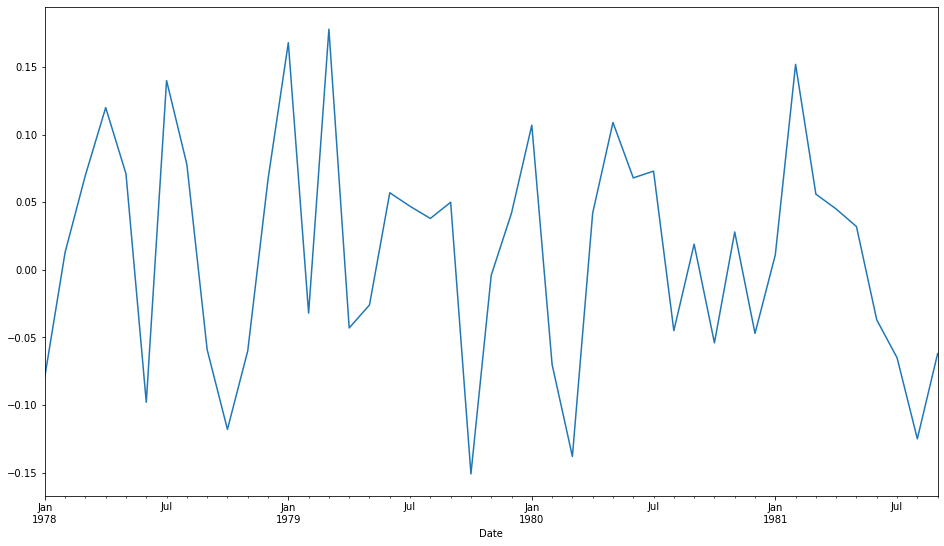

In [8]:
plt.rcParams["figure.figsize"]=[16,9]
BOISE_prices.plot()
plt.show

In [9]:
CONTIL_prices=df['CONTIL']
CONTIL_prices

Date
1978-01-01   -0.129
1978-02-01    0.037
1978-03-01    0.003
1978-04-01    0.180
1978-05-01    0.061
1978-06-01   -0.059
1978-07-01    0.066
1978-08-01    0.033
1978-09-01   -0.013
1978-10-01   -0.123
1978-11-01   -0.038
1978-12-01    0.047
1979-01-01   -0.024
1979-02-01   -0.020
1979-03-01    0.043
1979-04-01    0.064
1979-05-01    0.005
1979-06-01    0.092
1979-07-01   -0.034
1979-08-01    0.058
1979-09-01   -0.033
1979-10-01   -0.136
1979-11-01    0.081
1979-12-01    0.104
1980-01-01   -0.103
1980-02-01   -0.087
1980-03-01    0.085
1980-04-01    0.074
1980-05-01    0.023
1980-06-01    0.064
1980-07-01   -0.034
1980-08-01   -0.018
1980-09-01    0.034
1980-10-01    0.035
1980-11-01   -0.017
1980-12-01    0.103
1981-01-01    0.040
1981-02-01    0.069
1981-03-01    0.024
1981-04-01   -0.025
1981-05-01    0.117
1981-06-01    0.077
1981-07-01   -0.092
1981-08-01   -0.030
1981-09-01    0.003
Name: CONTIL, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

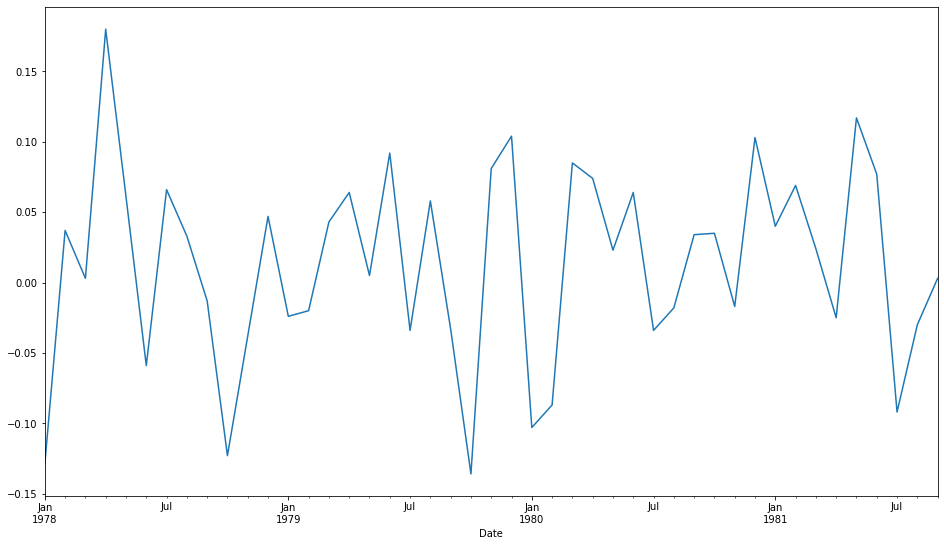

In [10]:
plt.rcParams["figure.figsize"]=[16,9]
CONTIL_prices.plot()
plt.show

In [11]:
df.columns

Index(['BOISE', 'CITCRP', 'CONED', 'CONTIL', 'DATGEN', 'DEC', 'DELTA',
       'GENMIL', 'GERBER', 'IBM', 'MARKET', 'MOBIL', 'MOTOR', 'PANAM', 'PSNH',
       'RKFREE', 'TANDY', 'TEXACO', 'WEYER', 'POIL', 'FRBIND', 'CPI', 'GPU',
       'DOW', 'DUPONT', 'GOLD', 'CONOCO'],
      dtype='object')

In [12]:
df1=df[['BOISE','CONTIL','MARKET']].copy()

In [13]:
df1.head(200)

,BOISE,CONTIL,MARKET
Date,,,
1978-01-01,-0.079,-0.129,-0.045
1978-02-01,0.013,0.037,0.010
1978-03-01,0.070,0.003,0.050
1978-04-01,0.120,0.180,0.063
1978-05-01,0.071,0.061,0.067
1978-06-01,-0.098,-0.059,0.007
1978-07-01,0.140,0.066,0.071
1978-08-01,0.078,0.033,0.079
1978-09-01,-0.059,-0.013,0.002


In [14]:
df1.head(150)

,BOISE,CONTIL,MARKET
Date,,,
1978-01-01,-0.079,-0.129,-0.045
1978-02-01,0.013,0.037,0.010
1978-03-01,0.070,0.003,0.050
1978-04-01,0.120,0.180,0.063
1978-05-01,0.071,0.061,0.067
1978-06-01,-0.098,-0.059,0.007
1978-07-01,0.140,0.066,0.071
1978-08-01,0.078,0.033,0.079
1978-09-01,-0.059,-0.013,0.002


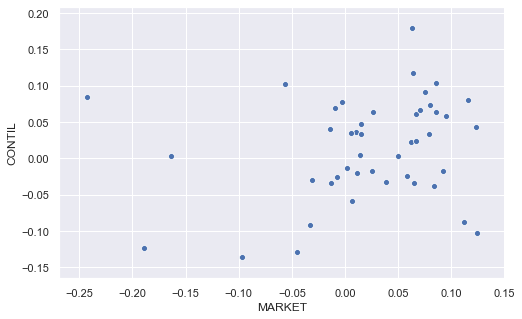

In [15]:
sns.set()
plt.figure(figsize=(8,5))
ax = sns.scatterplot(x='MARKET', y='CONTIL', data=df)

In [16]:
df1.head(100)

,BOISE,CONTIL,MARKET
Date,,,
1978-01-01,-0.079,-0.129,-0.045
1978-02-01,0.013,0.037,0.010
1978-03-01,0.070,0.003,0.050
1978-04-01,0.120,0.180,0.063
1978-05-01,0.071,0.061,0.067
1978-06-01,-0.098,-0.059,0.007
1978-07-01,0.140,0.066,0.071
1978-08-01,0.078,0.033,0.079
1978-09-01,-0.059,-0.013,0.002


In [17]:
df2=df1.copy()
df2=df2.sub(df.ix[:,-1],axis=0)
df2=df2.ix[:,:-1]

In [18]:
df2

,BOISE,CONTIL
Date,,
1978-01-01,0.03350,-0.01650
1978-02-01,-0.00015,0.02385
1978-03-01,0.06531,-0.00169
1978-04-01,0.06393,0.12393
1978-05-01,0.02321,0.01321
1978-06-01,0.00029,0.03929
1978-07-01,0.15422,0.08022
1978-08-01,-0.01719,-0.06219
1978-09-01,-0.10789,-0.06189


In [19]:
f=['BOISE','CONTIL']

In [20]:
f

['BOISE', 'CONTIL']

In [21]:
df2.columns=f

In [22]:
df2.head(100)

,BOISE,CONTIL
Date,,
1978-01-01,0.03350,-0.01650
1978-02-01,-0.00015,0.02385
1978-03-01,0.06531,-0.00169
1978-04-01,0.06393,0.12393
1978-05-01,0.02321,0.01321
1978-06-01,0.00029,0.03929
1978-07-01,0.15422,0.08022
1978-08-01,-0.01719,-0.06219
1978-09-01,-0.10789,-0.06189


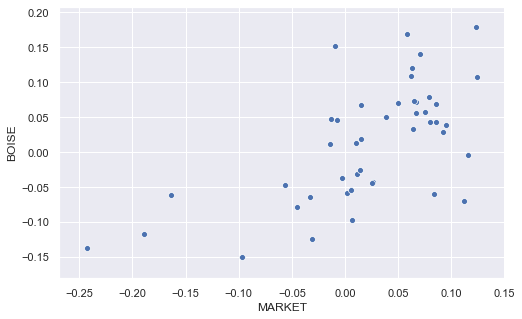

In [23]:
sns.set()
plt.figure(figsize=(8,5))
ax = sns.scatterplot(x='MARKET', y='BOISE', data=df)

In [24]:
df1.index

DatetimeIndex(['1978-01-01', '1978-02-01', '1978-03-01', '1978-04-01',
               '1978-05-01', '1978-06-01', '1978-07-01', '1978-08-01',
               '1978-09-01', '1978-10-01', '1978-11-01', '1978-12-01',
               '1979-01-01', '1979-02-01', '1979-03-01', '1979-04-01',
               '1979-05-01', '1979-06-01', '1979-07-01', '1979-08-01',
               '1979-09-01', '1979-10-01', '1979-11-01', '1979-12-01',
               '1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01', '1980-11-01', '1980-12-01',
               '1981-01-01', '1981-02-01', '1981-03-01', '1981-04-01',
               '1981-05-01', '1981-06-01', '1981-07-01', '1981-08-01',
               '1981-09-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [25]:
len(df1)

45

In [26]:
df3=df1.groupby(np.arange(len(df1))//(3*3))

In [27]:
np.arange(len(df1))//(3*3)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4])

In [28]:
df1['Group column']=np.arange(len(df1))//(3*3)

In [29]:
df1.head(200)

,BOISE,CONTIL,MARKET,Group column
Date,,,,
1978-01-01,-0.079,-0.129,-0.045,0
1978-02-01,0.013,0.037,0.010,0
1978-03-01,0.070,0.003,0.050,0
1978-04-01,0.120,0.180,0.063,0
1978-05-01,0.071,0.061,0.067,0
1978-06-01,-0.098,-0.059,0.007,0
1978-07-01,0.140,0.066,0.071,0
1978-08-01,0.078,0.033,0.079,0
1978-09-01,-0.059,-0.013,0.002,0


In [30]:
1986-1978

8

In [31]:
df_group_0=df3.get_group(0)
df_group_1=df3.get_group(1)
df_group_2=df3.get_group(2)
df_group_3=df3.get_group(3)

In [32]:
df_group_0
df.dropna()

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,
1978-01-01,-0.079,-0.115,-0.079,-0.129,-0.084,-0.100,-0.028,-0.099,-0.048,-0.029,...,-0.054,-0.116,8.68,138.8,187.2,-0.06874,-0.04673,-0.11319,0.07788,-0.11250
1978-02-01,0.013,-0.019,-0.003,0.037,-0.097,-0.063,-0.033,0.018,0.160,-0.043,...,-0.010,-0.135,8.84,139.2,188.4,0.01974,-0.11765,-0.07260,0.02821,0.01315
1978-03-01,0.070,0.059,0.022,0.003,0.063,0.010,0.070,-0.023,-0.036,-0.063,...,0.015,0.084,8.80,140.9,189.8,0.02581,0.05778,0.03453,0.03057,0.00469
1978-04-01,0.120,0.127,-0.005,0.180,0.179,0.165,0.150,0.046,0.004,0.130,...,0.000,0.144,8.82,143.2,191.5,-0.00931,0.14362,0.15451,-0.04548,0.05607
1978-05-01,0.071,0.005,-0.014,0.061,0.052,0.038,-0.031,0.063,0.046,-0.018,...,-0.029,-0.031,8.81,143.9,193.3,-0.03247,-0.04651,0.00000,0.00450,0.04779
1978-06-01,-0.098,0.007,0.034,-0.059,-0.023,-0.021,0.023,0.008,0.028,-0.004,...,-0.025,0.005,9.05,144.9,195.3,-0.00671,-0.02732,-0.03030,0.04295,-0.09829
1978-07-01,0.140,0.032,0.011,0.066,0.143,0.107,0.185,0.075,-0.012,0.092,...,0.042,0.164,8.96,146.1,196.7,0.04405,0.07107,0.07813,0.02814,-0.01422
1978-08-01,0.078,0.088,0.024,0.033,0.026,-0.017,-0.021,-0.051,-0.079,0.049,...,0.000,0.039,8.05,147.1,197.8,-0.04636,0.04265,0.03727,0.09005,0.09519
1978-09-01,-0.059,0.011,0.048,-0.013,-0.031,-0.037,-0.081,-0.012,0.104,-0.051,...,0.010,-0.021,9.15,147.8,199.3,0.03472,0.04000,0.03024,0.02977,0.04889


In [33]:
df2=df1.copy()
df2=df2.sub(df.ix[:,-1],axis=0)
df2=df2.ix[:,:-1]
df2.dropna()

,BOISE,CONTIL,MARKET
Date,,,
1978-01-01,0.03350,-0.01650,0.06750
1978-02-01,-0.00015,0.02385,-0.00315
1978-03-01,0.06531,-0.00169,0.04531
1978-04-01,0.06393,0.12393,0.00693
1978-05-01,0.02321,0.01321,0.01921
1978-06-01,0.00029,0.03929,0.10529
1978-07-01,0.15422,0.08022,0.08522
1978-08-01,-0.01719,-0.06219,-0.01619
1978-09-01,-0.10789,-0.06189,-0.04689


In [34]:
f=['BOISE','CONTIL','MARKET']

In [35]:
f

['BOISE', 'CONTIL', 'MARKET']

In [36]:
df2.columns=f

In [37]:
df2.head(100)

,BOISE,CONTIL,MARKET
Date,,,
1978-01-01,0.03350,-0.01650,0.06750
1978-02-01,-0.00015,0.02385,-0.00315
1978-03-01,0.06531,-0.00169,0.04531
1978-04-01,0.06393,0.12393,0.00693
1978-05-01,0.02321,0.01321,0.01921
1978-06-01,0.00029,0.03929,0.10529
1978-07-01,0.15422,0.08022,0.08522
1978-08-01,-0.01719,-0.06219,-0.01619
1978-09-01,-0.10789,-0.06189,-0.04689


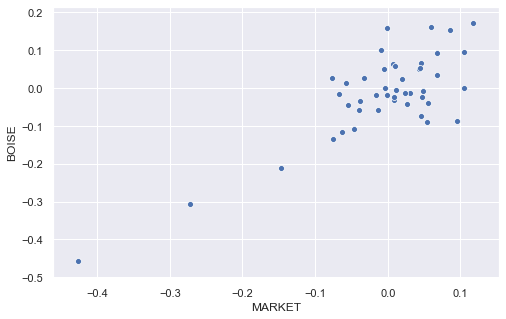

In [38]:
sns.set()
plt.figure(figsize=(8,5))
ax = sns.scatterplot(x='MARKET', y='BOISE', data=df2)

In [39]:
start_date = dt.datetime(1979,3,1)
end_date = dt.datetime(1987,2,1)
#greater than the start date and smaller than the end date
select = (df2.index>=start_date)*(df2.index<=end_date)

# Copy the selected dataframe into df2
df3=df2[select].copy()

In [40]:
df3.head(200)

,BOISE,CONTIL,MARKET
Date,,,
1979-03-01,0.05043,-0.08457,-0.00457
1979-04-01,-0.04300,0.06400,0.02600
1979-05-01,-0.03111,-0.00011,0.00889
1979-06-01,-0.05697,-0.02197,-0.03897
1979-07-01,0.02720,-0.05380,-0.03280
1979-08-01,-0.00860,0.01140,0.04840
1979-09-01,-0.04375,-0.12675,-0.05475
1979-10-01,-0.11671,-0.10171,-0.06271
1979-11-01,-0.07441,0.01059,0.04559


In [41]:
df4=df3[['CONTIL','MARKET']].copy()
df4.head(100)

,CONTIL,MARKET
Date,,
1979-03-01,-0.08457,-0.00457
1979-04-01,0.06400,0.02600
1979-05-01,-0.00011,0.00889
1979-06-01,-0.02197,-0.03897
1979-07-01,-0.05380,-0.03280
1979-08-01,0.01140,0.04840
1979-09-01,-0.12675,-0.05475
1979-10-01,-0.10171,-0.06271
1979-11-01,0.01059,0.04559


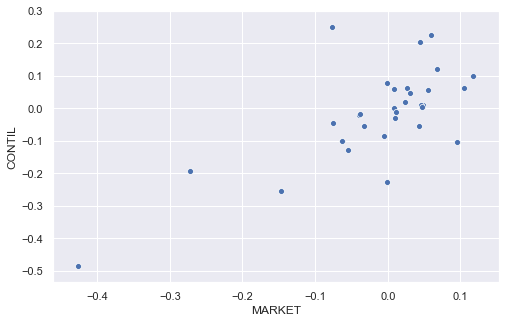

In [42]:
sns.set()
plt.figure(figsize=(8,5))
ax = sns.scatterplot(x='MARKET', y='CONTIL', data=df3)

In [43]:
choice_of_columns=['CONTIL', 'BOISE']
df6=Joining_columns(df3, 'MARKET', choice_of_columns, Name_of_new_column='Stock Return')
df6.head(100)

,MARKET,variable,Stock Return
0,-0.00457,CONTIL,-0.08457
1,0.02600,CONTIL,0.06400
2,0.00889,CONTIL,-0.00011
3,-0.03897,CONTIL,-0.02197
4,-0.03280,CONTIL,-0.05380
5,0.04840,CONTIL,0.01140
6,-0.05475,CONTIL,-0.12675
7,-0.06271,CONTIL,-0.10171
8,0.04559,CONTIL,0.01059
9,0.03013,CONTIL,0.04813


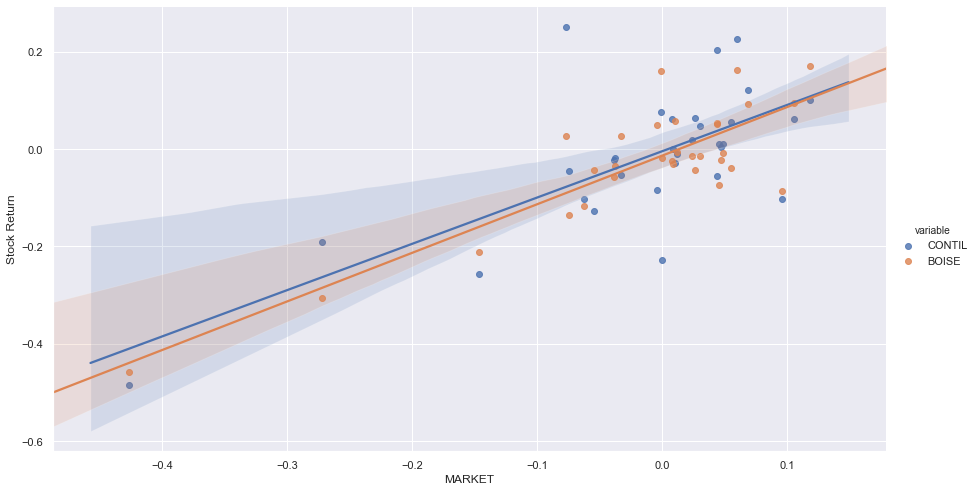

In [44]:
ig=sns.lmplot(x="MARKET", y="Stock Return", hue="variable", data=df6, height=7, aspect=1.8/1)

In [45]:
import statsmodels.formula.api as smf

In [46]:
formula = 'Q("CONTIL") ~ Q("MARKET")'
results = smf.ols(formula, df3).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Q("CONTIL")   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     29.04
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           8.60e-06
Time:                        14:38:32   Log-Likelihood:                 26.925
No. Observations:                  31   AIC:                            -49.85
Df Residuals:                      29   BIC:                            -46.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0043      0.019     -0.227      

In [47]:
formula = 'Q("BOISE") ~ Q("MARKET")'
results = smf.ols(formula, df3).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Q("BOISE")   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     71.25
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.66e-09
Time:                        14:38:32   Log-Likelihood:                 39.332
No. Observations:                  31   AIC:                            -74.66
Df Residuals:                      29   BIC:                            -71.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0134      0.013     -1.051      

In [48]:
df = pd.read_excel('Data_For_Analysis.xlsx')
df.set_index('Date', inplace=True)
df.tail(100)

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,
1979-08-01,0.038,0.065,-0.021,0.058,0.078,0.140,0.021,0.138,0.148,0.016,...,0.041,0.165,14.00,152.1,221.1,0.00000,0.09375,0.07034,0.02064,0.04660
1979-09-01,0.050,-0.017,0.000,-0.033,-0.031,-0.027,-0.026,-0.032,-0.009,-0.032,...,0.030,-0.015,14.57,152.7,223.4,-0.07692,0.07837,-0.02312,0.18394,0.09375
1979-10-01,-0.151,-0.125,-0.049,-0.136,-0.246,-0.010,-0.147,-0.067,-0.090,-0.079,...,-0.053,-0.083,15.11,152.7,225.4,-0.08333,-0.08812,-0.08284,0.09749,-0.03429
1979-11-01,-0.004,0.030,0.109,0.081,0.062,0.095,0.063,0.005,-0.014,0.060,...,0.067,-0.065,15.52,152.3,227.5,0.00000,0.07563,0.06452,0.00163,0.07041
1979-12-01,0.042,0.113,0.005,0.104,0.021,0.018,0.020,0.005,-0.036,-0.013,...,-0.029,0.104,17.03,152.5,229.9,0.07813,0.01641,0.00937,0.16912,0.05587
1980-01-01,0.107,-0.079,-0.039,-0.103,0.157,0.058,0.022,0.003,0.048,0.066,...,0.229,0.069,17.86,152.7,233.2,-0.05797,0.06226,0.00929,0.47437,0.12434
1980-02-01,-0.070,-0.080,-0.061,-0.087,0.043,0.034,-0.093,-0.096,-0.004,-0.062,...,0.161,0.033,18.81,152.6,236.4,-0.24615,0.02564,-0.05521,-0.01418,0.01600
1980-03-01,-0.138,-0.069,0.006,0.085,-0.094,-0.182,-0.031,0.011,-0.237,-0.122,...,-0.179,-0.129,19.34,152.1,239.8,-0.30612,-0.09571,-0.08882,-0.16820,-0.16589
1980-04-01,0.042,0.048,0.140,0.074,0.027,0.047,-0.018,0.059,0.027,-0.016,...,0.082,0.027,20.29,148.3,242.5,0.38235,0.04000,0.05415,-0.06696,0.05602


In [49]:
hypotheses = 'Q("MARKET")=0'
Simple_ttest_Ols(results, hypotheses, alternative='larger', level_of_sig = 0.05)

We reject the null hypothesis: Q("MARKET")=0 with a 5.0 % significance level


In [50]:
hypotheses = 'Q("MARKET")=1'
Simple_ttest_Ols(results, hypotheses, alternative='larger', level_of_sig = 0.05)

We accept the null hypothesis: Q("MARKET")=1 with a 5.0 % significance level


In [51]:
hypotheses = 'Q("MARKET")=1'
Simple_ttest_Ols(results, hypotheses, alternative='larger', level_of_sig = 0.05)

We accept the null hypothesis: Q("MARKET")=1 with a 5.0 % significance level


In [52]:
formula = 'CONTIL ~ MARKET'
results = smf.ols(formula, df1).fit()
std_residuals_CONTIL=results.resid
print(std_residuals_CONTIL.std())

0.06839421589721249


In [53]:
formula = 'BOISE ~ MARKET'
results = smf.ols(formula, df1).fit()
std_residuals_BOISE=results.resid
print(std_residuals_BOISE.std())

0.06435324835690541


In [54]:
df1.head(200)

,BOISE,CONTIL,MARKET,Group column
Date,,,,
1978-01-01,-0.079,-0.129,-0.045,0
1978-02-01,0.013,0.037,0.010,0
1978-03-01,0.070,0.003,0.050,0
1978-04-01,0.120,0.180,0.063,0
1978-05-01,0.071,0.061,0.067,0
1978-06-01,-0.098,-0.059,0.007,0
1978-07-01,0.140,0.066,0.071,0
1978-08-01,0.078,0.033,0.079,0
1978-09-01,-0.059,-0.013,0.002,0


In [55]:
df1.head(200)
df.dropna()

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,
1978-01-01,-0.079,-0.115,-0.079,-0.129,-0.084,-0.100,-0.028,-0.099,-0.048,-0.029,...,-0.054,-0.116,8.68,138.8,187.2,-0.06874,-0.04673,-0.11319,0.07788,-0.11250
1978-02-01,0.013,-0.019,-0.003,0.037,-0.097,-0.063,-0.033,0.018,0.160,-0.043,...,-0.010,-0.135,8.84,139.2,188.4,0.01974,-0.11765,-0.07260,0.02821,0.01315
1978-03-01,0.070,0.059,0.022,0.003,0.063,0.010,0.070,-0.023,-0.036,-0.063,...,0.015,0.084,8.80,140.9,189.8,0.02581,0.05778,0.03453,0.03057,0.00469
1978-04-01,0.120,0.127,-0.005,0.180,0.179,0.165,0.150,0.046,0.004,0.130,...,0.000,0.144,8.82,143.2,191.5,-0.00931,0.14362,0.15451,-0.04548,0.05607
1978-05-01,0.071,0.005,-0.014,0.061,0.052,0.038,-0.031,0.063,0.046,-0.018,...,-0.029,-0.031,8.81,143.9,193.3,-0.03247,-0.04651,0.00000,0.00450,0.04779
1978-06-01,-0.098,0.007,0.034,-0.059,-0.023,-0.021,0.023,0.008,0.028,-0.004,...,-0.025,0.005,9.05,144.9,195.3,-0.00671,-0.02732,-0.03030,0.04295,-0.09829
1978-07-01,0.140,0.032,0.011,0.066,0.143,0.107,0.185,0.075,-0.012,0.092,...,0.042,0.164,8.96,146.1,196.7,0.04405,0.07107,0.07813,0.02814,-0.01422
1978-08-01,0.078,0.088,0.024,0.033,0.026,-0.017,-0.021,-0.051,-0.079,0.049,...,0.000,0.039,8.05,147.1,197.8,-0.04636,0.04265,0.03727,0.09005,0.09519
1978-09-01,-0.059,0.011,0.048,-0.013,-0.031,-0.037,-0.081,-0.012,0.104,-0.051,...,0.010,-0.021,9.15,147.8,199.3,0.03472,0.04000,0.03024,0.02977,0.04889


In [56]:
formula_with_intercept = 'MARKET ~ BOISE + CONTIL'

results_with_intercept = smf.ols(formula_with_intercept, df1).fit()
print(results_with_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                 MARKET   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     14.03
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.16e-05
Time:                        14:38:45   Log-Likelihood:                 62.669
No. Observations:                  45   AIC:                            -119.3
Df Residuals:                      42   BIC:                            -113.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0146      0.009      1.543      0.1

In [57]:
R=GQTest(results_with_intercept)

The P vale of this test is 0.01935, which is smaller than the level of significance 0.05 therefore, we reject the null, hence the error terms are hetroscedastic


In [58]:
formula_without_intercept = 'MARKET ~ BOISE + CONTIL '

results_without_intercept = smf.ols(formula_without_intercept, df1).fit()
print(results_without_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                 MARKET   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     14.03
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.16e-05
Time:                        14:38:45   Log-Likelihood:                 62.669
No. Observations:                  45   AIC:                            -119.3
Df Residuals:                      42   BIC:                            -113.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0146      0.009      1.543      0.1

In [59]:
R=GQTest(results_without_intercept)

The P vale of this test is 0.01935, which is smaller than the level of significance 0.05 therefore, we reject the null, hence the error terms are hetroscedastic


In [60]:
R=WhiteTest(results_with_intercept)

The P vale of this test is 0.02118, which is smaller than the level of significance 0.05 therefore, we reject the null, hence the error terms are hetroscedastic


In [61]:
resid_model1=results_with_intercept.resid
resid_model1

Date
1978-01-01   -0.015748
1978-02-01   -0.011327
1978-03-01   -0.007143
1978-04-01   -0.018791
1978-05-01    0.011147
1978-06-01    0.050110
1978-07-01   -0.026699
1978-08-01    0.017968
1978-09-01    0.022872
1978-10-01   -0.135808
1978-11-01    0.104662
1978-12-01   -0.038876
1979-01-01   -0.059692
1979-02-01    0.015204
1979-03-01    0.001413
1979-04-01    0.039651
1979-05-01    0.015370
1979-06-01    0.028685
1979-07-01   -0.057351
1979-08-01    0.059140
1979-09-01   -0.007145
1979-10-01   -0.024142
1979-11-01    0.106463
1979-12-01    0.049210
1980-01-01    0.040861
1980-02-01    0.137147
1980-03-01   -0.170823
1980-04-01    0.042228
1980-05-01   -0.018233
1980-06-01    0.032071
1980-07-01    0.004819
1980-08-01    0.037185
1980-09-01   -0.010078
1980-10-01    0.025399
1980-11-01    0.059773
1980-12-01   -0.038637
1981-01-01   -0.034011
1981-02-01   -0.113907
1981-03-01    0.019068
1981-04-01   -0.050839
1981-05-01    0.033724
1981-06-01    0.007423
1981-07-01   -0.011061
1981-0

In [62]:
formula = 'Q("CONTIL") ~ Q("MARKET")'

results = smf.ols(formula, df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Q("CONTIL")   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     14.65
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           0.000209
Time:                        14:38:46   Log-Likelihood:                 63.430
No. Observations:                 119   AIC:                            -122.9
Df Residuals:                     117   BIC:                            -117.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0115      0.013     -0.858      

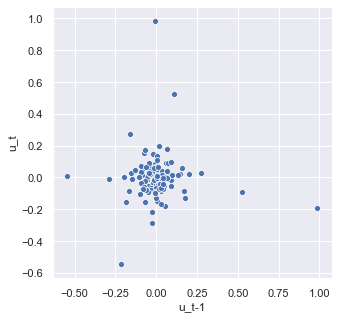

In [63]:
Plot_resi_corr(results)

,Residuals
Date,
1976-01-01,NaN
1976-02-01,NaN
1976-03-01,NaN
1976-04-01,NaN
1976-05-01,NaN
1976-06-01,NaN
1976-07-01,NaN
1976-08-01,NaN
1976-09-01,NaN


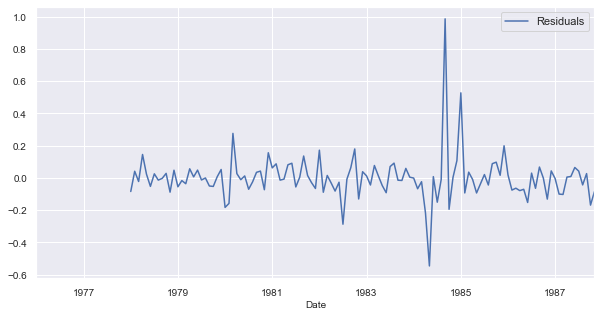

In [64]:
Plot_resi_corr_time(results,df)

In [65]:
import statsmodels.stats.stattools as tools
tools.durbin_watson(results.resid)

2.06843613615565

In [66]:
Breusch_Godfrey(results, lags=6, level_of_sig=0.1)

The P vale of this test is 0.81024, which is greater than the level of significance 0.1 therefore, we accept the null that the error terms are not Auto-corrolated


{'LM Statistic': 3.10673167028625,
 'LM-Test p-value': 0.7953366307235248,
 'F-Statistic': 0.4959264392887972,
 'F-Test p-value': 0.8102445238729414}

In [67]:
# Break the data into two sets
start_date = dt.datetime(1978,1,1)
end_date = dt.datetime(1987,12,1)

select = (df.index>=start_date)*(df.index<=end_date)

# Copy the selected dataframe into df1
df1=df[select].copy()
df1.head(100)

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,
1978-01-01,-0.079,-0.115,-0.079,-0.129,-0.084,-0.100,-0.028,-0.099,-0.048,-0.029,...,-0.054,-0.116,8.68,138.8,187.2,-0.06874,-0.04673,-0.11319,0.07788,-0.11250
1978-02-01,0.013,-0.019,-0.003,0.037,-0.097,-0.063,-0.033,0.018,0.160,-0.043,...,-0.010,-0.135,8.84,139.2,188.4,0.01974,-0.11765,-0.07260,0.02821,0.01315
1978-03-01,0.070,0.059,0.022,0.003,0.063,0.010,0.070,-0.023,-0.036,-0.063,...,0.015,0.084,8.80,140.9,189.8,0.02581,0.05778,0.03453,0.03057,0.00469
1978-04-01,0.120,0.127,-0.005,0.180,0.179,0.165,0.150,0.046,0.004,0.130,...,0.000,0.144,8.82,143.2,191.5,-0.00931,0.14362,0.15451,-0.04548,0.05607
1978-05-01,0.071,0.005,-0.014,0.061,0.052,0.038,-0.031,0.063,0.046,-0.018,...,-0.029,-0.031,8.81,143.9,193.3,-0.03247,-0.04651,0.00000,0.00450,0.04779
1978-06-01,-0.098,0.007,0.034,-0.059,-0.023,-0.021,0.023,0.008,0.028,-0.004,...,-0.025,0.005,9.05,144.9,195.3,-0.00671,-0.02732,-0.03030,0.04295,-0.09829
1978-07-01,0.140,0.032,0.011,0.066,0.143,0.107,0.185,0.075,-0.012,0.092,...,0.042,0.164,8.96,146.1,196.7,0.04405,0.07107,0.07813,0.02814,-0.01422
1978-08-01,0.078,0.088,0.024,0.033,0.026,-0.017,-0.021,-0.051,-0.079,0.049,...,0.000,0.039,8.05,147.1,197.8,-0.04636,0.04265,0.03727,0.09005,0.09519
1978-09-01,-0.059,0.011,0.048,-0.013,-0.031,-0.037,-0.081,-0.012,0.104,-0.051,...,0.010,-0.021,9.15,147.8,199.3,0.03472,0.04000,0.03024,0.02977,0.04889


In [68]:
select1 = (df.index>end_date)
df2=df[select1].copy()
df2.head(100)

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,


In [69]:
formula = 'Q("CONTIL") ~ Q("MARKET")'

results = smf.ols(formula, df1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Q("CONTIL")   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     14.65
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           0.000209
Time:                        14:39:02   Log-Likelihood:                 63.430
No. Observations:                 119   AIC:                            -122.9
Df Residuals:                     117   BIC:                            -117.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0115      0.013     -0.858      

In [70]:
formula = 'Q("BOISE") ~ Q("MARKET")'

results = smf.ols(formula, df1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Q("BOISE")   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     85.45
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.31e-15
Time:                        14:39:02   Log-Likelihood:                 141.64
No. Observations:                 119   AIC:                            -279.3
Df Residuals:                     117   BIC:                            -273.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0032      0.007      0.456      

(1.0162280527443794, 0.36510313332750644)

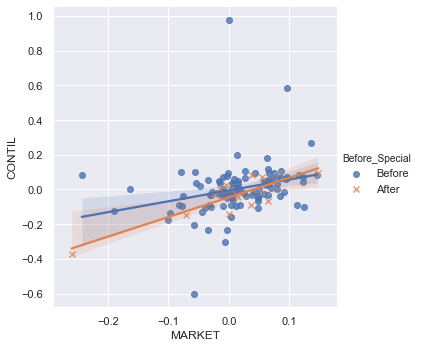

In [71]:
RF.Chow_Test(df1, y='CONTIL', x='MARKET', special_date='1986-11-01')

In [72]:
df.head(100)

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,
1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.90,125.9,166.7,0.05412,0.18281,0.24506,-0.10386,0.11499
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.87,127.6,167.1,-0.01429,0.02307,-0.02698,0.05101,-0.05525
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,128.3,167.5,0.01449,-0.02570,-0.04105,0.01071,0.06876
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.86,128.7,168.2,-0.01886,-0.00116,0.03425,-0.03494,0.00551
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.89,129.7,169.2,-0.01493,-0.08140,0.00911,-0.00771,0.02523
1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.99,129.8,170.1,0.01515,-0.01772,-0.07692,-0.00965,0.10432
1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.04,130.7,171.1,0.05493,-0.02591,-0.01254,-0.06505,-0.04235
1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.03,131.3,171.9,0.05797,-0.04255,-0.05626,-0.06703,0.01497
1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.39,130.6,172.6,0.04110,-0.00556,-0.01748,0.04142,0.04054


In [73]:
df1.head(100)

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO,Before_Special
Date,,,,,,,,,,,,,,,,,,,,,
1978-01-01,-0.079,-0.115,-0.079,-0.129,-0.084,-0.100,-0.028,-0.099,-0.048,-0.029,...,-0.116,8.68,138.8,187.2,-0.06874,-0.04673,-0.11319,0.07788,-0.11250,Before
1978-02-01,0.013,-0.019,-0.003,0.037,-0.097,-0.063,-0.033,0.018,0.160,-0.043,...,-0.135,8.84,139.2,188.4,0.01974,-0.11765,-0.07260,0.02821,0.01315,Before
1978-03-01,0.070,0.059,0.022,0.003,0.063,0.010,0.070,-0.023,-0.036,-0.063,...,0.084,8.80,140.9,189.8,0.02581,0.05778,0.03453,0.03057,0.00469,Before
1978-04-01,0.120,0.127,-0.005,0.180,0.179,0.165,0.150,0.046,0.004,0.130,...,0.144,8.82,143.2,191.5,-0.00931,0.14362,0.15451,-0.04548,0.05607,Before
1978-05-01,0.071,0.005,-0.014,0.061,0.052,0.038,-0.031,0.063,0.046,-0.018,...,-0.031,8.81,143.9,193.3,-0.03247,-0.04651,0.00000,0.00450,0.04779,Before
1978-06-01,-0.098,0.007,0.034,-0.059,-0.023,-0.021,0.023,0.008,0.028,-0.004,...,0.005,9.05,144.9,195.3,-0.00671,-0.02732,-0.03030,0.04295,-0.09829,Before
1978-07-01,0.140,0.032,0.011,0.066,0.143,0.107,0.185,0.075,-0.012,0.092,...,0.164,8.96,146.1,196.7,0.04405,0.07107,0.07813,0.02814,-0.01422,Before
1978-08-01,0.078,0.088,0.024,0.033,0.026,-0.017,-0.021,-0.051,-0.079,0.049,...,0.039,8.05,147.1,197.8,-0.04636,0.04265,0.03727,0.09005,0.09519,Before
1978-09-01,-0.059,0.011,0.048,-0.013,-0.031,-0.037,-0.081,-0.012,0.104,-0.051,...,-0.021,9.15,147.8,199.3,0.03472,0.04000,0.03024,0.02977,0.04889,Before


In [74]:
formula_with_intercept = 'BOISE ~ MARKET + CPI + FRBIND'

results_with_intercept = smf.ols(formula_with_intercept, df1).fit()
print(results_with_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                  BOISE   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     28.91
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           5.27e-14
Time:                        14:39:12   Log-Likelihood:                 142.46
No. Observations:                 119   AIC:                            -276.9
Df Residuals:                     115   BIC:                            -265.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0426      0.096     -0.445      0.6

In [75]:
df.head(100)

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,
1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.90,125.9,166.7,0.05412,0.18281,0.24506,-0.10386,0.11499
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.87,127.6,167.1,-0.01429,0.02307,-0.02698,0.05101,-0.05525
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,128.3,167.5,0.01449,-0.02570,-0.04105,0.01071,0.06876
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.86,128.7,168.2,-0.01886,-0.00116,0.03425,-0.03494,0.00551
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.89,129.7,169.2,-0.01493,-0.08140,0.00911,-0.00771,0.02523
1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.99,129.8,170.1,0.01515,-0.01772,-0.07692,-0.00965,0.10432
1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.04,130.7,171.1,0.05493,-0.02591,-0.01254,-0.06505,-0.04235
1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.03,131.3,171.9,0.05797,-0.04255,-0.05626,-0.06703,0.01497
1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.39,130.6,172.6,0.04110,-0.00556,-0.01748,0.04142,0.04054


In [76]:
df4=df1[['BOISE','CONTIL','MARKET', 'CPI', 'POIL', 'FRBIND']].dropna()
df4['RINF']=df4['CPI'].pct_change(1)
df4['GIND']=df4['FRBIND'].pct_change(1)
df4['real_POIL']=df4['POIL']/df4['CPI']
df4['ROIL']=df4['real_POIL'].pct_change(1)
df4.head(100)

,BOISE,CONTIL,MARKET,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,
1978-01-01,-0.079,-0.129,-0.045,187.2,8.68,138.8,NaN,NaN,0.046368,NaN
1978-02-01,0.013,0.037,0.010,188.4,8.84,139.2,0.006410,0.002882,0.046921,0.011946
1978-03-01,0.070,0.003,0.050,189.8,8.80,140.9,0.007431,0.012213,0.046365,-0.011868
1978-04-01,0.120,0.180,0.063,191.5,8.82,143.2,0.008957,0.016324,0.046057,-0.006625
1978-05-01,0.071,0.061,0.067,193.3,8.81,143.9,0.009399,0.004888,0.045577,-0.010435
1978-06-01,-0.098,-0.059,0.007,195.3,9.05,144.9,0.010347,0.006949,0.046339,0.016722
1978-07-01,0.140,0.066,0.071,196.7,8.96,146.1,0.007168,0.008282,0.045552,-0.016991
1978-08-01,0.078,0.033,0.079,197.8,8.05,147.1,0.005592,0.006845,0.040698,-0.106559
1978-09-01,-0.059,-0.013,0.002,199.3,9.15,147.8,0.007583,0.004759,0.045911,0.128091


In [77]:
formula_without_intercept = 'CONTIL ~ MARKET + RINF + GIND + ROIL'

results_without_intercept = smf.ols(formula_without_intercept, df4).fit()
print(results_without_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                 CONTIL   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     3.988
Date:                Wed, 18 Dec 2019   Prob (F-statistic):            0.00460
Time:                        14:39:21   Log-Likelihood:                 63.586
No. Observations:                 118   AIC:                            -117.2
Df Residuals:                     113   BIC:                            -103.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0096      0.024     -0.399      0.6

In [78]:
formula_without_intercept = 'BOISE ~ MARKET + RINF + GIND + ROIL'

results_without_intercept = smf.ols(formula_without_intercept, df4).fit()
print(results_without_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                  BOISE   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     23.97
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.26e-14
Time:                        14:39:22   Log-Likelihood:                 144.34
No. Observations:                 118   AIC:                            -278.7
Df Residuals:                     113   BIC:                            -264.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0320      0.012      2.630      0.0

In [79]:
df3.head(100)
df.dropna()

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,
1978-01-01,-0.079,-0.115,-0.079,-0.129,-0.084,-0.100,-0.028,-0.099,-0.048,-0.029,...,-0.054,-0.116,8.68,138.8,187.2,-0.06874,-0.04673,-0.11319,0.07788,-0.11250
1978-02-01,0.013,-0.019,-0.003,0.037,-0.097,-0.063,-0.033,0.018,0.160,-0.043,...,-0.010,-0.135,8.84,139.2,188.4,0.01974,-0.11765,-0.07260,0.02821,0.01315
1978-03-01,0.070,0.059,0.022,0.003,0.063,0.010,0.070,-0.023,-0.036,-0.063,...,0.015,0.084,8.80,140.9,189.8,0.02581,0.05778,0.03453,0.03057,0.00469
1978-04-01,0.120,0.127,-0.005,0.180,0.179,0.165,0.150,0.046,0.004,0.130,...,0.000,0.144,8.82,143.2,191.5,-0.00931,0.14362,0.15451,-0.04548,0.05607
1978-05-01,0.071,0.005,-0.014,0.061,0.052,0.038,-0.031,0.063,0.046,-0.018,...,-0.029,-0.031,8.81,143.9,193.3,-0.03247,-0.04651,0.00000,0.00450,0.04779
1978-06-01,-0.098,0.007,0.034,-0.059,-0.023,-0.021,0.023,0.008,0.028,-0.004,...,-0.025,0.005,9.05,144.9,195.3,-0.00671,-0.02732,-0.03030,0.04295,-0.09829
1978-07-01,0.140,0.032,0.011,0.066,0.143,0.107,0.185,0.075,-0.012,0.092,...,0.042,0.164,8.96,146.1,196.7,0.04405,0.07107,0.07813,0.02814,-0.01422
1978-08-01,0.078,0.088,0.024,0.033,0.026,-0.017,-0.021,-0.051,-0.079,0.049,...,0.000,0.039,8.05,147.1,197.8,-0.04636,0.04265,0.03727,0.09005,0.09519
1978-09-01,-0.059,0.011,0.048,-0.013,-0.031,-0.037,-0.081,-0.012,0.104,-0.051,...,0.010,-0.021,9.15,147.8,199.3,0.03472,0.04000,0.03024,0.02977,0.04889


In [80]:
np.percentile(df3['CONTIL'],25)

-0.069975

In [81]:
np.percentile(df3['BOISE'],25)

-0.05036

In [82]:
print("25th percentile of CONTIL stock ", np.percentile(df3['CONTIL'],25))

25th percentile of CONTIL stock  -0.069975


In [83]:
print("25th percentile of CONTIL stock ", np.percentile(df3['CONTIL'],25))
print("75th percentile of CONTIL stock ", np.percentile(df3['CONTIL'],75))

25th percentile of CONTIL stock  -0.069975
75th percentile of CONTIL stock  0.06158


In [84]:
IQR=np.percentile(df3['CONTIL'],75)-np.percentile(df3['CONTIL'],25)
IQR

0.131555

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1fa13550>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1fb60400>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1fa130f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c1fb60b00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c1fb60e80>],
 'means': []}

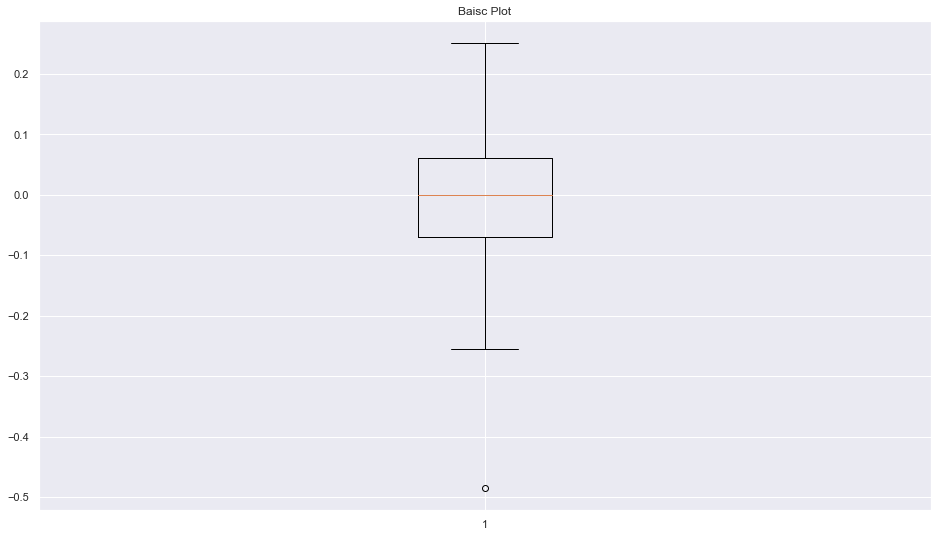

In [85]:
fig1, ax1 = plt.subplots()
ax1.set_title('Baisc Plot')
ax1.boxplot(df3['CONTIL'])

In [86]:
df =pd.read_excel('Data_For_Analysis.xlsx')
df.head(80)

,Date,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
0,1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.90,125.9,166.7,0.05412,0.18281,0.24506,-0.10386,0.11499
1,1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.87,127.6,167.1,-0.01429,0.02307,-0.02698,0.05101,-0.05525
2,1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,128.3,167.5,0.01449,-0.02570,-0.04105,0.01071,0.06876
3,1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.86,128.7,168.2,-0.01886,-0.00116,0.03425,-0.03494,0.00551
4,1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.89,129.7,169.2,-0.01493,-0.08140,0.00911,-0.00771,0.02523
5,1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.99,129.8,170.1,0.01515,-0.01772,-0.07692,-0.00965,0.10432
6,1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.04,130.7,171.1,0.05493,-0.02591,-0.01254,-0.06505,-0.04235
7,1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.03,131.3,171.9,0.05797,-0.04255,-0.05626,-0.06703,0.01497
8,1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.39,130.6,172.6,0.04110,-0.00556,-0.01748,0.04142,0.04054
9,1976-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.46,130.2,173.3,-0.01737,-0.01966,0.02174,0.01736,-0.05065


In [87]:
df =pd.read_excel('Data_For_Analysis.xlsx')
df.head(80)

,Date,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
0,1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.90,125.9,166.7,0.05412,0.18281,0.24506,-0.10386,0.11499
1,1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.87,127.6,167.1,-0.01429,0.02307,-0.02698,0.05101,-0.05525
2,1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,128.3,167.5,0.01449,-0.02570,-0.04105,0.01071,0.06876
3,1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.86,128.7,168.2,-0.01886,-0.00116,0.03425,-0.03494,0.00551
4,1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.89,129.7,169.2,-0.01493,-0.08140,0.00911,-0.00771,0.02523
5,1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.99,129.8,170.1,0.01515,-0.01772,-0.07692,-0.00965,0.10432
6,1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.04,130.7,171.1,0.05493,-0.02591,-0.01254,-0.06505,-0.04235
7,1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.03,131.3,171.9,0.05797,-0.04255,-0.05626,-0.06703,0.01497
8,1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.39,130.6,172.6,0.04110,-0.00556,-0.01748,0.04142,0.04054
9,1976-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.46,130.2,173.3,-0.01737,-0.01966,0.02174,0.01736,-0.05065


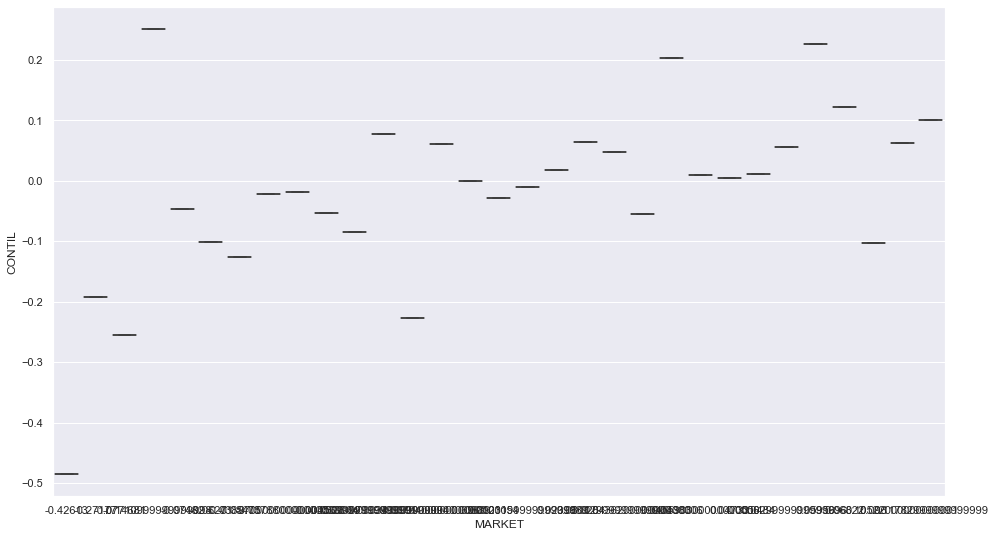

In [88]:
sns.boxplot(x="MARKET", y='CONTIL', data=df3, palette="Set1")

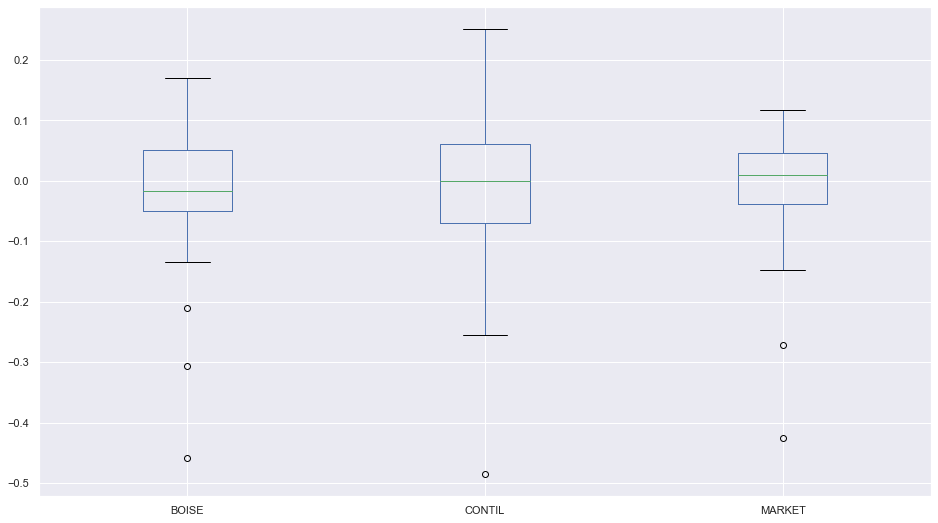

In [89]:
boxplot = df3.boxplot()

In [90]:
df3.var()

BOISE     0.016534
CONTIL    0.021317
MARKET    0.011777
dtype: float64

In [91]:
df3.std
df3.dropna()

,BOISE,CONTIL,MARKET
Date,,,
1979-03-01,0.05043,-0.08457,-0.00457
1979-04-01,-0.04300,0.06400,0.02600
1979-05-01,-0.03111,-0.00011,0.00889
1979-06-01,-0.05697,-0.02197,-0.03897
1979-07-01,0.02720,-0.05380,-0.03280
1979-08-01,-0.00860,0.01140,0.04840
1979-09-01,-0.04375,-0.12675,-0.05475
1979-10-01,-0.11671,-0.10171,-0.06271
1979-11-01,-0.07441,0.01059,0.04559


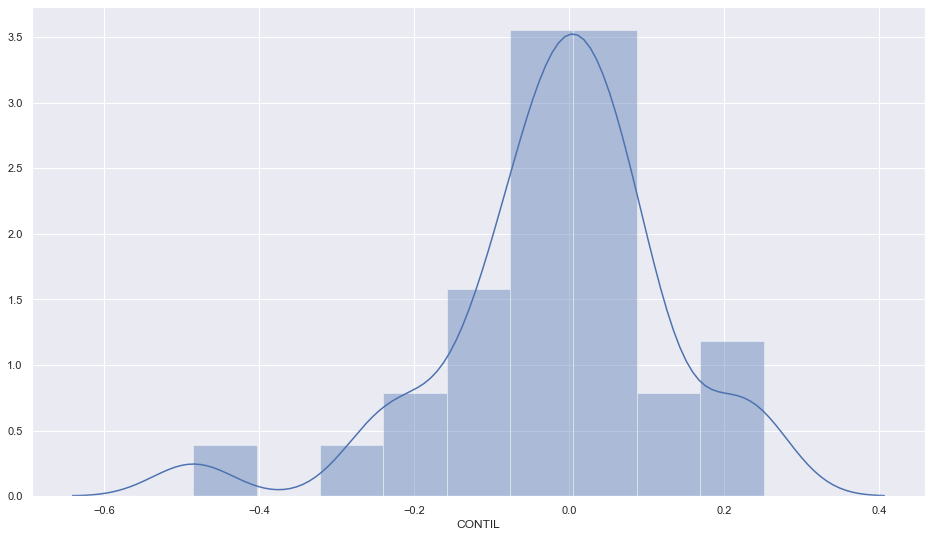

In [92]:
sns.distplot(df3['CONTIL'])

In [93]:
m, s = stats.norm.fit(df3['CONTIL'])

In [94]:
m

-0.015955161290322577

In [95]:
s

0.14362765395219923

In [96]:
m, s = stats.norm.fit(df3['BOISE'])

In [97]:
m

-0.025600322580645162

In [98]:
s

0.12649389666479696

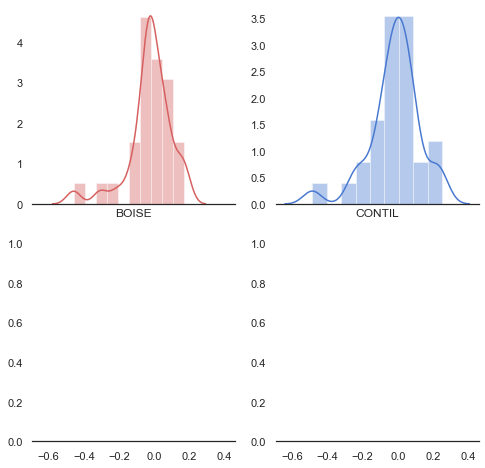

In [99]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
sns.despine(left=True)

sns.distplot(df3['BOISE'], color="r", ax=axes[0,0])
sns.distplot(df3['CONTIL'], color="b", ax=axes[0,1])

In [100]:
df1.var()/df1.mean()

BOISE      0.604939
CITCRP     0.576942
CONED      0.135915
CONTIL   -14.960264
DATGEN     2.679905
DEC        0.521622
DELTA      0.852008
GENMIL     0.265865
GERBER     0.485193
IBM        0.375298
MARKET     0.346923
MOBIL      0.422214
MOTOR      0.442681
PANAM      2.697942
PSNH      -9.911186
RKFREE     0.000681
TANDY      0.659466
TEXACO     0.585124
WEYER      0.816287
POIL       2.842325
FRBIND     0.873288
CPI        7.680525
GPU        1.956240
DOW        0.453628
DUPONT     0.317565
GOLD       0.660820
CONOCO     0.455283
dtype: float64

In [101]:
formula ='CONTIL ~ MARKET + RINF + GIND + ROIL'
results = smf.ols(formula, df4).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 CONTIL   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     3.988
Date:                Wed, 18 Dec 2019   Prob (F-statistic):            0.00460
Time:                        14:39:43   Log-Likelihood:                 63.586
No. Observations:                 118   AIC:                            -117.2
Df Residuals:                     113   BIC:                            -103.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0096      0.024     -0.399      0.6

In [102]:
hypotheses = 'GIND=0, ROIL=0'
f_test=results.f_test(hypotheses)
print(f_test)

<F test: F=array([[0.84148198]]), p=0.43375422200985014, df_denom=113, df_num=2>


In [103]:
formula ='CONTIL ~ MARKET + RINF + ROIL'
results = smf.ols(formula, df4).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 CONTIL   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.867
Date:                Wed, 18 Dec 2019   Prob (F-statistic):            0.00319
Time:                        14:39:43   Log-Likelihood:                 62.906
No. Observations:                 118   AIC:                            -117.8
Df Residuals:                     114   BIC:                            -106.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0142      0.024     -0.595      0.5

In [104]:
formula ='CONTIL ~ MARKET + RINF + ROIL + GIND'
results = smf.ols(formula, df4).fit()
hypotheses = 'GIND'
wald_0 = results.wald_test(hypotheses)
print('H0:', hypotheses)
print(wald_0)

H0: GIND
<F test: F=array([[1.31001863]]), p=0.25480985797858324, df_denom=113, df_num=1>


In [105]:
df1.head(100)

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO,Before_Special
Date,,,,,,,,,,,,,,,,,,,,,
1978-01-01,-0.079,-0.115,-0.079,-0.129,-0.084,-0.100,-0.028,-0.099,-0.048,-0.029,...,-0.116,8.68,138.8,187.2,-0.06874,-0.04673,-0.11319,0.07788,-0.11250,Before
1978-02-01,0.013,-0.019,-0.003,0.037,-0.097,-0.063,-0.033,0.018,0.160,-0.043,...,-0.135,8.84,139.2,188.4,0.01974,-0.11765,-0.07260,0.02821,0.01315,Before
1978-03-01,0.070,0.059,0.022,0.003,0.063,0.010,0.070,-0.023,-0.036,-0.063,...,0.084,8.80,140.9,189.8,0.02581,0.05778,0.03453,0.03057,0.00469,Before
1978-04-01,0.120,0.127,-0.005,0.180,0.179,0.165,0.150,0.046,0.004,0.130,...,0.144,8.82,143.2,191.5,-0.00931,0.14362,0.15451,-0.04548,0.05607,Before
1978-05-01,0.071,0.005,-0.014,0.061,0.052,0.038,-0.031,0.063,0.046,-0.018,...,-0.031,8.81,143.9,193.3,-0.03247,-0.04651,0.00000,0.00450,0.04779,Before
1978-06-01,-0.098,0.007,0.034,-0.059,-0.023,-0.021,0.023,0.008,0.028,-0.004,...,0.005,9.05,144.9,195.3,-0.00671,-0.02732,-0.03030,0.04295,-0.09829,Before
1978-07-01,0.140,0.032,0.011,0.066,0.143,0.107,0.185,0.075,-0.012,0.092,...,0.164,8.96,146.1,196.7,0.04405,0.07107,0.07813,0.02814,-0.01422,Before
1978-08-01,0.078,0.088,0.024,0.033,0.026,-0.017,-0.021,-0.051,-0.079,0.049,...,0.039,8.05,147.1,197.8,-0.04636,0.04265,0.03727,0.09005,0.09519,Before
1978-09-01,-0.059,0.011,0.048,-0.013,-0.031,-0.037,-0.081,-0.012,0.104,-0.051,...,-0.021,9.15,147.8,199.3,0.03472,0.04000,0.03024,0.02977,0.04889,Before


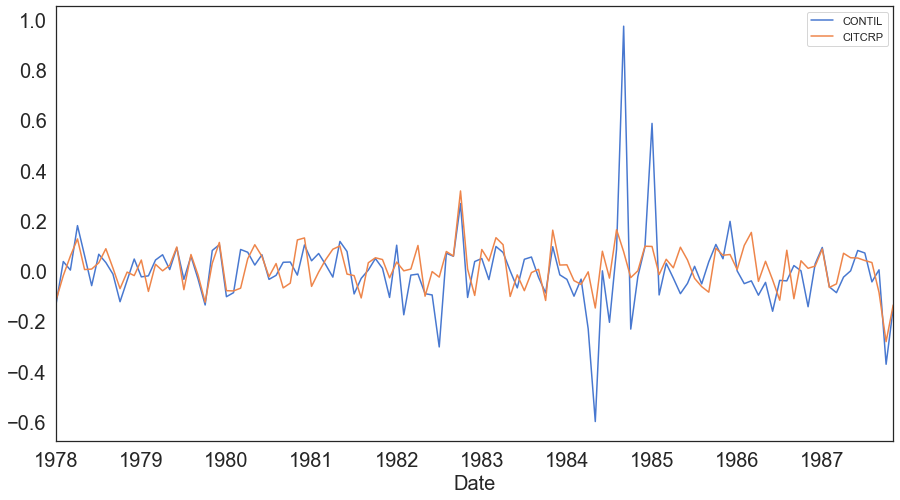

In [106]:
df1[['CONTIL','CITCRP']].plot(figsize=(15,8),linewidth=1.5,fontsize=20)
plt.xlabel('Date',fontsize=20);

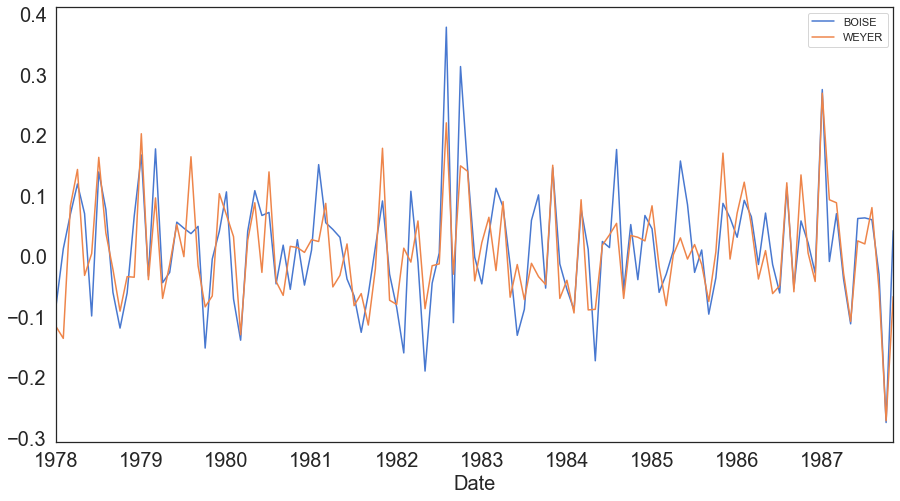

In [107]:
df1[['BOISE','WEYER']].plot(figsize=(15,8),linewidth=1.5,fontsize=20)
plt.xlabel('Date',fontsize=20);

In [108]:
formula = 'Q("CONTIL") ~ Q("MARKET")'
results = smf.ols(formula, df3).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Q("CONTIL")   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     29.04
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           8.60e-06
Time:                        14:39:49   Log-Likelihood:                 26.925
No. Observations:                  31   AIC:                            -49.85
Df Residuals:                      29   BIC:                            -46.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0043      0.019     -0.227      

In [109]:
hypotheses = 'Intercept=0'
Simple_ttest_Ols(results, hypotheses, alternative='larger', level_of_sig = 0.05)

We accept the null hypothesis: Intercept=0 with a 5.0 % significance level


In [110]:
hypotheses = 'Q("MARKET")=0'
Simple_ttest_Ols(results, hypotheses, alternative='smaller', level_of_sig = 0.05)

We accept the null hypothesis: Q("MARKET")=0 with a 5.0 % significance level


In [111]:
formula = 'Q("CITCRP") ~ Q("MARKET")'
results = smf.ols(formula, df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Q("CITCRP")   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     53.95
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.99e-11
Time:                        14:39:49   Log-Likelihood:                 153.04
No. Observations:                 119   AIC:                            -302.1
Df Residuals:                     117   BIC:                            -296.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0024      0.006      0.385      

In [112]:
hypotheses = 'Q("MARKET")=0'
Simple_ttest_Ols(results, hypotheses, alternative='smaller', level_of_sig = 0.05)

We accept the null hypothesis: Q("MARKET")=0 with a 5.0 % significance level


In [113]:
hypotheses = 'Intercept=0'
Simple_ttest_Ols(results, hypotheses, alternative='larger', level_of_sig = 0.05)

We accept the null hypothesis: Intercept=0 with a 5.0 % significance level


In [114]:
formula = 'Q("CONTIL") ~ Q("MARKET")'

results = smf.ols(formula, df1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Q("CONTIL")   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     14.65
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           0.000209
Time:                        14:39:49   Log-Likelihood:                 63.430
No. Observations:                 119   AIC:                            -122.9
Df Residuals:                     117   BIC:                            -117.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0115      0.013     -0.858      

(2.5869412758378107, 0.07951319460600349)

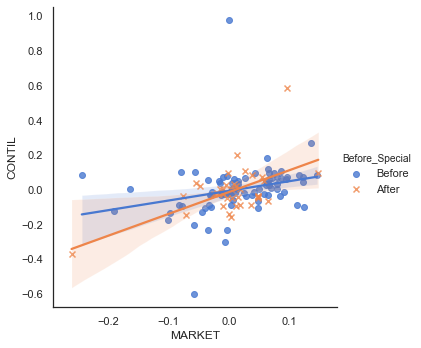

In [115]:
RF.Chow_Test(df1, y='CONTIL', x='MARKET', special_date='1984-11-01')

In [116]:
formula = 'Q("BOISE") ~ Q("MARKET")'

results = smf.ols(formula, df1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Q("BOISE")   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     85.45
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.31e-15
Time:                        14:39:50   Log-Likelihood:                 141.64
No. Observations:                 119   AIC:                            -279.3
Df Residuals:                     117   BIC:                            -273.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0032      0.007      0.456      

(1.0439225070169136, 0.35529933592969426)

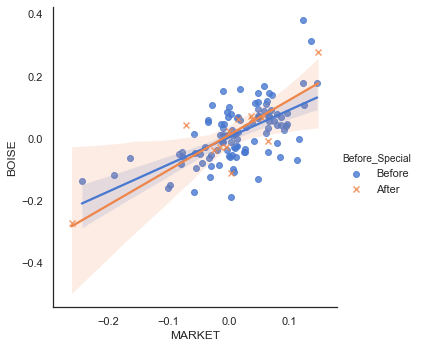

In [117]:
RF.Chow_Test(df1, y='BOISE', x='MARKET', special_date='1986-11-01')

In [118]:
formula = 'Q("CONTIL") ~ Q("MARKET")'
results = smf.ols(formula, df1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Q("CONTIL")   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     14.65
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           0.000209
Time:                        14:39:51   Log-Likelihood:                 63.430
No. Observations:                 119   AIC:                            -122.9
Df Residuals:                     117   BIC:                            -117.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0115      0.013     -0.858      

In [119]:
formula = 'Q("BOISE") ~ Q("MARKET")'
results = smf.ols(formula, df1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Q("BOISE")   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     85.45
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.31e-15
Time:                        14:39:51   Log-Likelihood:                 141.64
No. Observations:                 119   AIC:                            -279.3
Df Residuals:                     117   BIC:                            -273.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0032      0.007      0.456      

In [120]:
df.head(100)

,Date,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
0,1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.90,125.9,166.7,0.05412,0.18281,0.24506,-0.10386,0.11499
1,1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.87,127.6,167.1,-0.01429,0.02307,-0.02698,0.05101,-0.05525
2,1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,128.3,167.5,0.01449,-0.02570,-0.04105,0.01071,0.06876
3,1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.86,128.7,168.2,-0.01886,-0.00116,0.03425,-0.03494,0.00551
4,1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.89,129.7,169.2,-0.01493,-0.08140,0.00911,-0.00771,0.02523
5,1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.99,129.8,170.1,0.01515,-0.01772,-0.07692,-0.00965,0.10432
6,1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.04,130.7,171.1,0.05493,-0.02591,-0.01254,-0.06505,-0.04235
7,1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.03,131.3,171.9,0.05797,-0.04255,-0.05626,-0.06703,0.01497
8,1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.39,130.6,172.6,0.04110,-0.00556,-0.01748,0.04142,0.04054
9,1976-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.46,130.2,173.3,-0.01737,-0.01966,0.02174,0.01736,-0.05065


In [121]:
static,pvalue=ss.jarque_bera(df3['CONTIL'])

In [122]:
static

9.75995360623815

In [123]:
pvalue

0.007597190256651287

In [124]:
print('The test statistic is given by {} and the P-value is given by {}'.format(static, pvalue))

The test statistic is given by 9.75995360623815 and the P-value is given by 0.007597190256651287


In [125]:
static,pvalue=ss.kstest(df3['CONTIL'], 'norm')
print('The test statistic is given by {} and the P-value is given by {}'.format(static, pvalue))

The test statistic is given by 0.4009495780206833 and the P-value is given by 5.191736905658404e-05


In [126]:
static,pvalue=statsmodels.stats._adnorm.normal_ad(df3['CONTIL'])
print('The test statistic is given by {} and the P-value is given by {}'.format(static, pvalue))

The test statistic is given by 0.6431851643635831 and the P-value is given by 0.08479062672413287


In [127]:
static,pvalue=ss.shapiro(df3['CONTIL'])
print('The test statistic is given by {} and the P-value is given by {}'.format(static, pvalue))

The test statistic is given by 0.9337706565856934 and the P-value is given by 0.05558066442608833


In [128]:
static,pvalue=ss.jarque_bera(df3['BOISE'])

In [129]:
static

20.667853044913137

In [130]:
pvalue

3.251118017322252e-05

In [131]:
static,pvalue=ss.kstest(df3['BOISE'], 'norm')
print('The test statistic is given by {} and the P-value is given by {}'.format(static, pvalue))

The test statistic is given by 0.43217871960473353 and the P-value is given by 8.857278685089354e-06


In [132]:
static,pvalue=statsmodels.stats._adnorm.normal_ad(df3['BOISE'])
print('The test statistic is given by {} and the P-value is given by {}'.format(static, pvalue))

The test statistic is given by 1.1523255888499122 and the P-value is given by 0.004367941102311427


In [133]:
static,pvalue=ss.shapiro(df3['BOISE'])
print('The test statistic is given by {} and the P-value is given by {}'.format(static, pvalue))

The test statistic is given by 0.8807262182235718 and the P-value is given by 0.002462482312694192


In [134]:
df.head()

,Date,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
0,1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.90,125.9,166.7,0.05412,0.18281,0.24506,-0.10386,0.11499
1,1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.87,127.6,167.1,-0.01429,0.02307,-0.02698,0.05101,-0.05525
2,1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,128.3,167.5,0.01449,-0.02570,-0.04105,0.01071,0.06876
3,1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.86,128.7,168.2,-0.01886,-0.00116,0.03425,-0.03494,0.00551
4,1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.89,129.7,169.2,-0.01493,-0.08140,0.00911,-0.00771,0.02523


In [135]:

df = pd.read_excel('Data_For_Analysis.xlsx')
df.set_index('Date', inplace=True)

df.columns
# df=df.dropna()

Index(['BOISE', 'CITCRP', 'CONED', 'CONTIL', 'DATGEN', 'DEC', 'DELTA',
       'GENMIL', 'GERBER', 'IBM', 'MARKET', 'MOBIL', 'MOTOR', 'PANAM', 'PSNH',
       'RKFREE', 'TANDY', 'TEXACO', 'WEYER', 'POIL', 'FRBIND', 'CPI', 'GPU',
       'DOW', 'DUPONT', 'GOLD', 'CONOCO'],
      dtype='object')

In [202]:
MainDF=df[['CONTIL','IBM','MARKET','RKFREE','CPI','POIL','FRBIND']]
MainDF=MainDF.dropna()
MainDF.head(100)

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND
Date,,,,,,,
1978-01-01,-0.129,-0.029,-0.045,0.00487,187.2,8.68,138.8
1978-02-01,0.037,-0.043,0.010,0.00494,188.4,8.84,139.2
1978-03-01,0.003,-0.063,0.050,0.00526,189.8,8.80,140.9
1978-04-01,0.180,0.130,0.063,0.00491,191.5,8.82,143.2
1978-05-01,0.061,-0.018,0.067,0.00513,193.3,8.81,143.9
1978-06-01,-0.059,-0.004,0.007,0.00527,195.3,9.05,144.9
1978-07-01,0.066,0.092,0.071,0.00528,196.7,8.96,146.1
1978-08-01,0.033,0.049,0.079,0.00607,197.8,8.05,147.1
1978-09-01,-0.013,-0.051,0.002,0.00645,199.3,9.15,147.8


In [137]:
MainDF.index

DatetimeIndex(['1978-01-01', '1978-02-01', '1978-03-01', '1978-04-01',
               '1978-05-01', '1978-06-01', '1978-07-01', '1978-08-01',
               '1978-09-01', '1978-10-01',
               ...
               '1987-02-01', '1987-03-01', '1987-04-01', '1987-05-01',
               '1987-06-01', '1987-07-01', '1987-08-01', '1987-09-01',
               '1987-10-01', '1987-11-01'],
              dtype='datetime64[ns]', name='Date', length=119, freq=None)

In [138]:
MainDF['RINF']=MainDF['CPI'].pct_change(1)
MainDF['GIND']=MainDF['FRBIND'].pct_change(1)
MainDF['real_POIL']=MainDF['POIL']/MainDF['CPI']
MainDF['ROIL']=MainDF['real_POIL'].pct_change(1)

MainDF.head()

,MOBIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1978-01-01,-0.046,-0.029,-0.045,0.00487,187.2,8.68,138.8,NaN,NaN,0.046368,NaN
1978-02-01,-0.017,-0.043,0.010,0.00494,188.4,8.84,139.2,0.006410,0.002882,0.046921,0.011946
1978-03-01,0.049,-0.063,0.050,0.00526,189.8,8.80,140.9,0.007431,0.012213,0.046365,-0.011868
1978-04-01,0.077,0.130,0.063,0.00491,191.5,8.82,143.2,0.008957,0.016324,0.046057,-0.006625
1978-05-01,-0.011,-0.018,0.067,0.00513,193.3,8.81,143.9,0.009399,0.004888,0.045577,-0.010435


In [139]:
MainDF=MainDF.dropna()
MainDF.head()

,MOBIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1978-02-01,-0.017,-0.043,0.010,0.00494,188.4,8.84,139.2,0.006410,0.002882,0.046921,0.011946
1978-03-01,0.049,-0.063,0.050,0.00526,189.8,8.80,140.9,0.007431,0.012213,0.046365,-0.011868
1978-04-01,0.077,0.130,0.063,0.00491,191.5,8.82,143.2,0.008957,0.016324,0.046057,-0.006625
1978-05-01,-0.011,-0.018,0.067,0.00513,193.3,8.81,143.9,0.009399,0.004888,0.045577,-0.010435
1978-06-01,-0.043,-0.004,0.007,0.00527,195.3,9.05,144.9,0.010347,0.006949,0.046339,0.016722


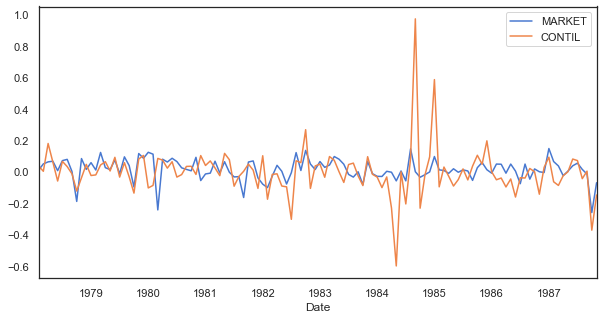

In [212]:
plt.rcParams["figure.figsize"] = [10,5]
MainDF[['MARKET', 'CONTIL']].plot()

In [217]:
    MainDF[MainDF['CONTIL']== MainDF['CONTIL'].max()]

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1984-09-01,0.974,0.004,0.0,0.0083,314.5,25.97,165.0,0.004792,-0.006024,0.082576,-0.006682


In [218]:
start_date = dt.datetime(1978,1,1)
end_date = dt.datetime(1980,1,1)

start_date2 = dt.datetime(1980,1,1)
end_date2 = dt.datetime(1985,1,1)

select = (MainDF.index>=start_date)*(MainDF.index<end_date)

select2 = (MainDF.index>=start_date2)*(MainDF.index<end_date2)

MainDF_first_period=MainDF[select]
MainDF_second_period=MainDF[select2]


In [219]:
MainDF_first_period.head()

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1978-02-01,0.037,-0.043,0.010,0.00494,188.4,8.84,139.2,0.006410,0.002882,0.046921,0.011946
1978-03-01,0.003,-0.063,0.050,0.00526,189.8,8.80,140.9,0.007431,0.012213,0.046365,-0.011868
1978-04-01,0.180,0.130,0.063,0.00491,191.5,8.82,143.2,0.008957,0.016324,0.046057,-0.006625
1978-05-01,0.061,-0.018,0.067,0.00513,193.3,8.81,143.9,0.009399,0.004888,0.045577,-0.010435
1978-06-01,-0.059,-0.004,0.007,0.00527,195.3,9.05,144.9,0.010347,0.006949,0.046339,0.016722


In [220]:
MainDF_first_period.tail(2)

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1979-11-01,0.081,0.060,0.116,0.00819,227.5,15.52,152.3,0.009317,-0.002620,0.068220,0.017653
1979-12-01,0.104,-0.013,0.086,0.00747,229.9,17.03,152.5,0.010549,0.001313,0.074076,0.085839


In [145]:
MainDF_second_period.head(2)

,MOBIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1980-01-01,0.075,0.066,0.124,0.00883,233.2,17.86,152.7,0.014354,0.001311,0.076587,0.033897
1980-02-01,0.366,-0.062,0.112,0.01073,236.4,18.81,152.6,0.013722,-0.000655,0.079569,0.038935


In [146]:
MainDF_second_period.tail(2)

,MOBIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1984-11-01,-0.042,-0.023,-0.019,0.00602,315.3,25.44,165.2,0.000000,0.004255,0.080685,-0.018519
1984-12-01,-0.052,0.011,-0.001,0.00612,315.5,25.05,166.2,0.000634,0.006053,0.079398,-0.015954


In [221]:
formula = 'CONTIL ~ MARKET'
results_Mobil_period1 = smf.ols(formula, MainDF_first_period).fit()
print(results_Mobil_period1.summary())

                            OLS Regression Results                            
Dep. Variable:                 CONTIL   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     22.03
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           0.000124
Time:                        16:20:38   Log-Likelihood:                 36.492
No. Observations:                  23   AIC:                            -68.98
Df Residuals:                      21   BIC:                            -66.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0088      0.012     -0.726      0.4

In [222]:
formula = 'CONTIL ~ MARKET + RINF + GIND + ROIL'
results_Mobil_Secondmodel_period1 = smf.ols(formula, MainDF_first_period).fit()
print(results_Mobil_Secondmodel_period1.summary())

                            OLS Regression Results                            
Dep. Variable:                 CONTIL   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     4.988
Date:                Wed, 18 Dec 2019   Prob (F-statistic):            0.00696
Time:                        16:20:49   Log-Likelihood:                 36.821
No. Observations:                  23   AIC:                            -63.64
Df Residuals:                      18   BIC:                            -57.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0475      0.062     -0.769      0.4

In [223]:
hypotheses = 'RINF=0, GIND=0, ROIL=0'
f_test=results_Mobil_Secondmodel_period1.f_test(hypotheses)
print(f_test)

<F test: F=array([[0.17434189]]), p=0.9123562285533326, df_denom=18, df_num=3>


In [224]:
resi_Model_1=results_Mobil_period1.resid
resi_Model_2=results_Mobil_Secondmodel_period1.resid

In [225]:
resi_Model_1.std()

0.050624668794528864

In [226]:
resi_Model_2.std()

0.04990481881444332

In [227]:
wald_0 = results_Mobil_Secondmodel_period1.wald_test(hypotheses)
print('H0:', hypotheses)
print(wald_0)

H0: RINF=0, GIND=0, ROIL=0
<F test: F=array([[0.17434189]]), p=0.9123562285533326, df_denom=18, df_num=3>


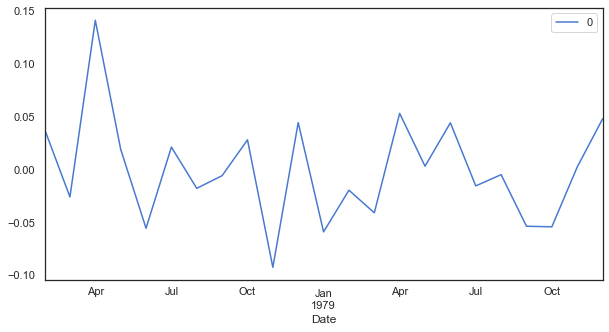

In [228]:
residuals=pd.DataFrame(resi_Model_1)
residuals.plot()

,Residuals
Date,
1978-02-01,0.049545
1978-03-01,-0.022220
1978-04-01,0.136730
1978-05-01,0.018437
1978-06-01,-0.062015
1978-07-01,0.027997
1978-08-01,-0.000652
1978-09-01,-0.004416
1978-10-01,0.032938


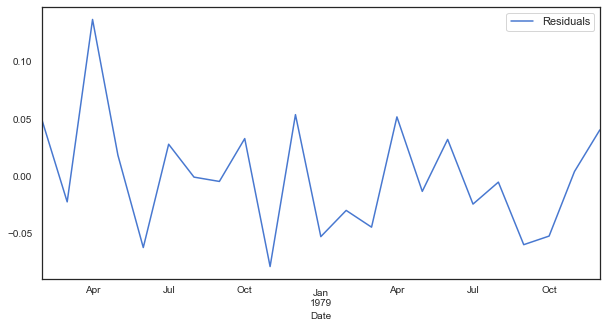

In [229]:
Plot_resi_corr_time(results_Mobil_Secondmodel_period1,MainDF_first_period)

In [230]:
print(resi_Model_1.describe())

count    2.300000e+01
mean     3.921984e-18
std      5.062467e-02
min     -9.246818e-02
25%     -3.335145e-02
50%     -4.754541e-03
75%      3.323031e-02
max      1.413512e-01
dtype: float64


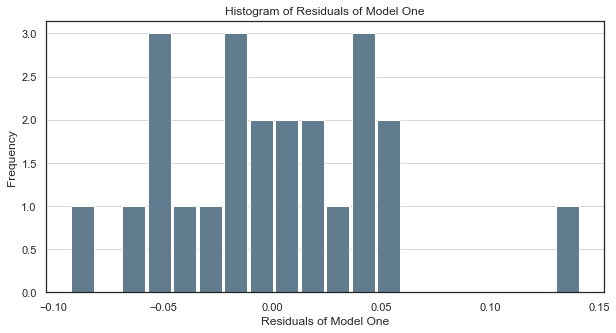

In [231]:
Figure=resi_Model_1.plot.hist(grid=False, bins=20, rwidth=0.9,
                                    color='#607c8e')
plt.title('Histogram of Residuals of Model One')
plt.xlabel('Residuals of Model One')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [234]:
Adj_df= Create_lags_of_variable(MainDF_first_period, lags=[1,2], column='CONTIL')
Adj_df.head()

,CONTIL for time t-2,CONTIL for time t-1,CONTIL for time t-0
Date,,,
1978-04-01,0.037,0.003,0.180
1978-05-01,0.003,0.180,0.061
1978-06-01,0.180,0.061,-0.059
1978-07-01,0.061,-0.059,0.066
1978-08-01,-0.059,0.066,0.033


In [235]:
Adj_df1=Create_lags_of_variable(MainDF_first_period, lags=3, column='CONTIL')
Adj_df1.head()

,CONTIL at time t-3,CONTIL at time t
Date,,
1978-05-01,0.037,0.061
1978-06-01,0.003,-0.059
1978-07-01,0.180,0.066
1978-08-01,0.061,0.033
1978-09-01,-0.059,-0.013


In [236]:
Adj_df= Create_lags_of_variable(MainDF_first_period, lags=[1,2,3], column='CONTIL')
Adj_df.head()

,CONTIL for time t-3,CONTIL for time t-2,CONTIL for time t-1,CONTIL for time t-0
Date,,,,
1978-05-01,0.037,0.003,0.180,0.061
1978-06-01,0.003,0.180,0.061,-0.059
1978-07-01,0.180,0.061,-0.059,0.066
1978-08-01,0.061,-0.059,0.066,0.033
1978-09-01,-0.059,0.066,0.033,-0.013


In [237]:
Adj_df.cov()

,CONTIL for time t-3,CONTIL for time t-2,CONTIL for time t-1,CONTIL for time t-0
CONTIL for time t-3,0.004234,0.000363,-0.000880,0.000672
CONTIL for time t-2,0.000363,0.005371,-0.000179,-0.001827
CONTIL for time t-1,-0.000880,-0.000179,0.005629,0.000234
CONTIL for time t-0,0.000672,-0.001827,0.000234,0.004578


In [238]:
Adj_df.corr()

,CONTIL for time t-3,CONTIL for time t-2,CONTIL for time t-1,CONTIL for time t-0
CONTIL for time t-3,1.000000,0.076213,-0.180310,0.152744
CONTIL for time t-2,0.076213,1.000000,-0.032594,-0.368462
CONTIL for time t-1,-0.180310,-0.032594,1.000000,0.046181
CONTIL for time t-0,0.152744,-0.368462,0.046181,1.000000


In [239]:
smt.stattools.acovf(MainDF_first_period['CONTIL'])[:5]

array([ 5.02254820e-03,  1.15328183e-04, -1.30599770e-03,  5.54623490e-04,
        7.23278540e-05])

In [240]:
smt.stattools.acf(MainDF_first_period['CONTIL'])[:5]

array([ 1.        ,  0.02296209, -0.26002691,  0.11042671,  0.01440063])

In [241]:
LujungStatitic, Pvalue=sms.diagnostic.acorr_ljungbox(MainDF_first_period['CONTIL'], lags=15)

In [242]:
LujungStatitic

array([ 0.01378059,  1.86511616,  2.21569536,  2.22197128,  2.51331336,
        5.79369477,  6.16667323,  6.67289896,  6.69039293,  7.83214627,
        9.62068974, 11.26534231, 11.30084601, 11.88387249, 12.80880527])

In [243]:
Pvalue

array([0.90655041, 0.3935457 , 0.5288635 , 0.69500887, 0.77448873,
       0.44669298, 0.52042835, 0.57229989, 0.66931804, 0.6452286 ,
       0.56479404, 0.50632614, 0.58563063, 0.61562829, 0.61706293])

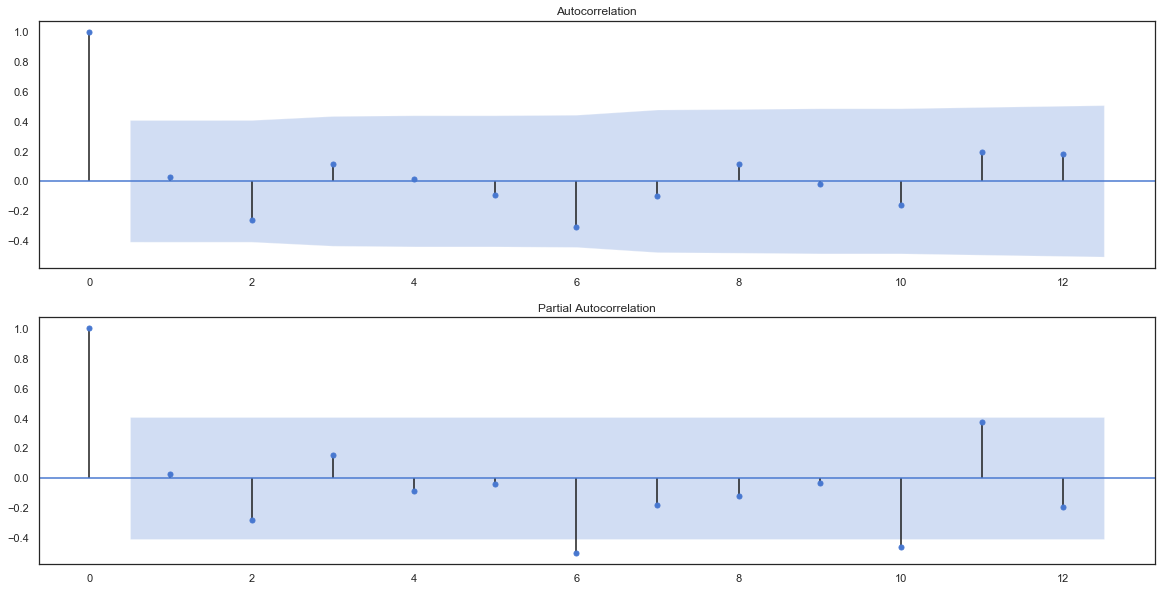

In [244]:
plt.rcParams["figure.figsize"] = [20,10]
pyplot.figure()
pyplot.subplot(211)
smgtsplot.plot_acf(MainDF_first_period['CONTIL'], lags=12,  ax=pyplot.gca())
pyplot.subplot(212)

smgtsplot.plot_pacf(MainDF_first_period['CONTIL'], lags=12, ax=pyplot.gca())
pyplot.show()

In [245]:
acf,q,pval = smt.acf(MainDF_first_period['CONTIL'],nlags=12,qstat=True)
pacf = smt.pacf(MainDF_first_period['CONTIL'],nlags=12)

correlogram = pd.DataFrame({'acf':acf[1:],
                            'pacf':pacf[1:],
                            'Q':q,
                            'p-val':pval})
correlogram

,acf,pacf,Q,p-val
0,0.022962,0.024006,0.013781,0.906550
1,-0.260027,-0.285532,1.865116,0.393546
2,0.110427,0.155384,2.215695,0.528863
3,0.014401,-0.087671,2.221971,0.695009
4,-0.095500,-0.039645,2.513313,0.774489
5,-0.311424,-0.504251,5.793695,0.446693
6,-0.101875,-0.184599,6.166673,0.520428
7,0.114917,-0.122394,6.672899,0.572300
8,-0.020638,-0.034259,6.690393,0.669318
9,-0.160666,-0.460632,7.832146,0.645229


In [246]:
x=MainDF_first_period['CONTIL']
a= smt.stattools.arma_order_select_ic(x, max_ar=5, max_ma=3, ic=['aic', 'bic', 'hqic'])

In [247]:
a

{'aic':            0          1          2          3
 0 -52.486638 -50.514004 -51.856820 -49.609435
 1 -50.499138 -50.846145 -50.516722 -47.802699
 2 -50.157470 -49.327535 -49.710367 -46.841670
 3 -48.996520 -47.649060 -47.799412 -44.899620
 4 -47.044130 -49.105173        NaN -44.650059
 5 -45.180742        NaN        NaN        NaN,
 'bic':            0          1          2          3
 0 -50.215650 -47.107521 -47.314843 -43.931964
 1 -47.092655 -46.304168 -44.839251 -40.989734
 2 -45.615493 -43.650064 -42.897402 -38.893211
 3 -43.319049 -40.836095 -39.850952 -35.815666
 4 -40.231164 -41.156713        NaN -34.430611
 5 -37.232283        NaN        NaN        NaN,
 'hqic':            0          1          2          3
 0 -51.915491 -49.657283 -50.714525 -48.181567
 1 -49.642417 -49.703851 -49.088854 -46.089257
 2 -49.015176 -47.899667 -47.996926 -44.842655
 3 -47.568652 -45.935619 -45.800396 -42.615031
 4 -45.330688 -47.106157        NaN -42.079896
 5 -43.181727        NaN        NaN 

In [248]:
res=smt.ARIMA(MainDF_first_period['CONTIL'], order=(0,0,1)).fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                 CONTIL   No. Observations:                   23
Model:                     ARMA(0, 1)   Log Likelihood                  28.257
Method:                       css-mle   S.D. of innovations              0.071
Date:                Wed, 18 Dec 2019   AIC                            -50.514
Time:                        16:56:04   BIC                            -47.108
Sample:                    02-01-1978   HQIC                           -49.657
                         - 12-01-1979                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0174      0.016      1.116      0.277      -0.013       0.048
ma.L1.CONTIL     0.0521      0.316      0.165      0.871      -0.568       0.672
                                    Roots   

In [250]:
res=smt.ARIMA(MainDF_first_period['CONTIL'], order=(2,0,1)).fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                 CONTIL   No. Observations:                   23
Model:                     ARMA(2, 1)   Log Likelihood                  29.664
Method:                       css-mle   S.D. of innovations              0.064
Date:                Wed, 18 Dec 2019   AIC                            -49.328
Time:                        16:56:24   BIC                            -43.650
Sample:                    02-01-1978   HQIC                           -47.900
                         - 12-01-1979                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0176      0.014      1.266      0.221      -0.010       0.045
ar.L1.CONTIL    -0.7729      0.213     -3.631      0.002      -1.190      -0.356
ar.L2.CONTIL    -0.1487      0.211     -0.70

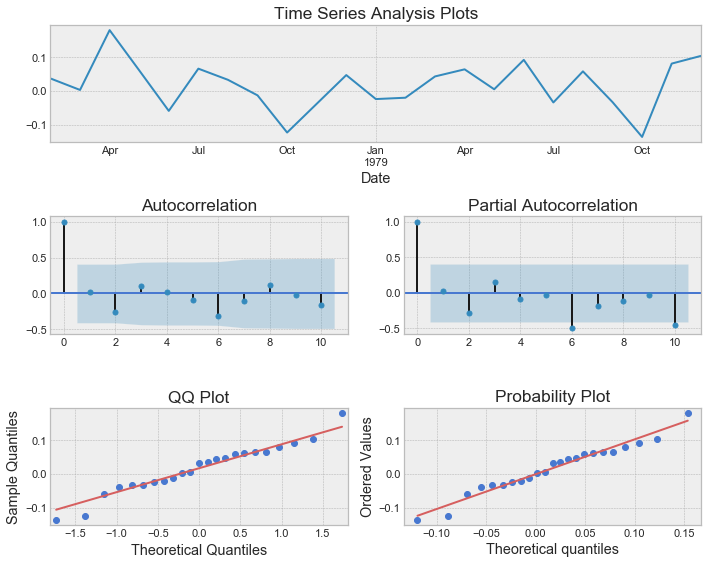

In [251]:
RF.tsplot(MainDF_first_period['CONTIL'], lags=10)

In [252]:
MainDF.index.get_loc('1980-02-01')

24

In [253]:
MainDF.index.get_loc('1983-02-01')

60

In [254]:
df.head()

,BOISE,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,...,TEXACO,WEYER,POIL,FRBIND,CPI,GPU,DOW,DUPONT,GOLD,CONOCO
Date,,,,,,,,,,,,,,,,,,,,,
1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.90,125.9,166.7,0.05412,0.18281,0.24506,-0.10386,0.11499
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.87,127.6,167.1,-0.01429,0.02307,-0.02698,0.05101,-0.05525
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,128.3,167.5,0.01449,-0.02570,-0.04105,0.01071,0.06876
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.86,128.7,168.2,-0.01886,-0.00116,0.03425,-0.03494,0.00551
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.89,129.7,169.2,-0.01493,-0.08140,0.00911,-0.00771,0.02523


In [255]:
train=MainDF[0:25] 
test=MainDF[25:61]

In [256]:
train.head()

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1978-02-01,0.037,-0.043,0.010,0.00494,188.4,8.84,139.2,0.006410,0.002882,0.046921,0.011946
1978-03-01,0.003,-0.063,0.050,0.00526,189.8,8.80,140.9,0.007431,0.012213,0.046365,-0.011868
1978-04-01,0.180,0.130,0.063,0.00491,191.5,8.82,143.2,0.008957,0.016324,0.046057,-0.006625
1978-05-01,0.061,-0.018,0.067,0.00513,193.3,8.81,143.9,0.009399,0.004888,0.045577,-0.010435
1978-06-01,-0.059,-0.004,0.007,0.00527,195.3,9.05,144.9,0.010347,0.006949,0.046339,0.016722


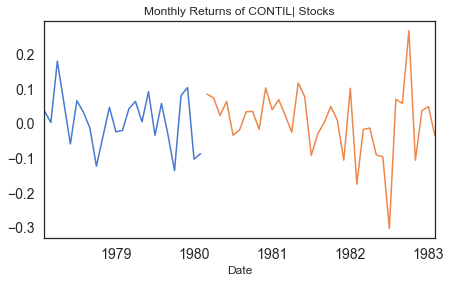

In [259]:
train['CONTIL'].plot(figsize=(7,4), title= 'Monthly Returns of CONTIL Stocks', fontsize=14)
test['CONTIL'].plot(figsize=(7,4), title= 'Monthly Returns of CONTIL| Stocks', fontsize=14)
plt.show()

In [260]:

df1 = MainDF.resample('Y').mean()
df1

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1978-12-31,0.017636,0.016818,0.023545,0.005841,196.209091,8.938182,145.600000,0.007530,0.007330,0.045563,0.001733
1979-12-31,0.016667,-0.007417,0.044417,0.007783,217.441667,12.611667,152.508333,0.010300,0.001180,0.057661,0.040099
1980-12-31,0.013250,0.010750,0.030667,0.008521,246.816667,21.605833,146.858333,0.009793,-0.001261,0.087353,0.025363
1981-12-31,0.011333,-0.008917,-0.003250,0.010513,272.350000,31.850833,150.891667,0.007165,-0.003692,0.117087,0.009196
1982-12-31,-0.022167,0.050750,0.006750,0.007848,289.150000,28.535833,138.600000,0.003181,-0.005170,0.098732,-0.010297
1983-12-31,0.015250,0.024250,0.023500,0.006703,298.416667,26.133333,147.558333,0.003112,0.012435,0.087595,-0.009905
1984-12-31,-0.025333,0.004667,-0.006583,0.007182,311.150000,25.880833,163.450000,0.003238,0.005200,0.083194,-0.005912
1985-12-31,0.058583,0.024000,0.015250,0.005637,322.191667,24.075000,166.733333,0.003090,0.001303,0.074728,-0.004734
1986-12-31,-0.047250,-0.018083,0.005917,0.004506,328.383333,12.450833,168.108333,0.000941,0.000708,0.037921,-0.052466


In [261]:
df_out_sample= test.copy()
df_in_sample=train.copy()

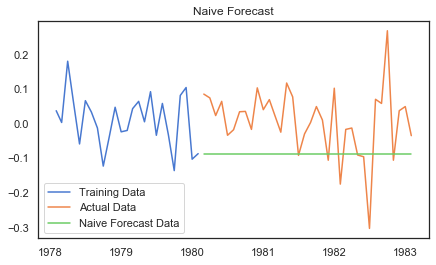

In [262]:

f_Method_NF=RF.Naive_Forecast(df_in_sample, df_out_sample, 'CONTIL')

In [263]:
f_Method_NF.head()

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
0,-0.087,-0.062,0.112,0.01073,236.4,18.81,152.6,0.013722,-0.000655,0.079569,0.038935
1,-0.087,-0.062,0.112,0.01073,236.4,18.81,152.6,0.013722,-0.000655,0.079569,0.038935
2,-0.087,-0.062,0.112,0.01073,236.4,18.81,152.6,0.013722,-0.000655,0.079569,0.038935
3,-0.087,-0.062,0.112,0.01073,236.4,18.81,152.6,0.013722,-0.000655,0.079569,0.038935
4,-0.087,-0.062,0.112,0.01073,236.4,18.81,152.6,0.013722,-0.000655,0.079569,0.038935


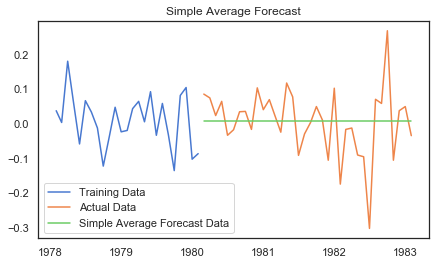

In [264]:
f_Method_AF=RF.Average_Forecast(df_in_sample, df_out_sample, 'CONTIL')

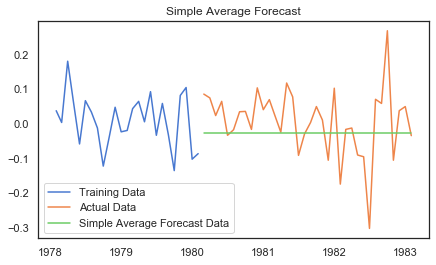

In [266]:
f_Method_MAF=RF.Moving_Average_Forecast(df_in_sample, df_out_sample, 'CONTIL', 3)

In [191]:
f_Method_MAF.head()

,MOBIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1980-03-01,0.168,-0.003,0.107333,0.00901,233.166667,17.9,152.6,0.012875,0.000657,0.076744,0.05289
1980-04-01,0.168,-0.003,0.107333,0.00901,233.166667,17.9,152.6,0.012875,0.000657,0.076744,0.05289
1980-05-01,0.168,-0.003,0.107333,0.00901,233.166667,17.9,152.6,0.012875,0.000657,0.076744,0.05289
1980-06-01,0.168,-0.003,0.107333,0.00901,233.166667,17.9,152.6,0.012875,0.000657,0.076744,0.05289
1980-07-01,0.168,-0.003,0.107333,0.00901,233.166667,17.9,152.6,0.012875,0.000657,0.076744,0.05289


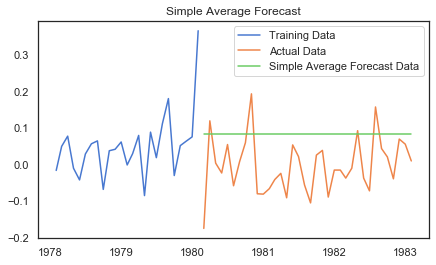

In [192]:
f_Method_MAF_1=RF.Moving_Average_Forecast(df_in_sample, df_out_sample, 'MOBIL', 10)

In [193]:
f_Method_MAF_1.head()

,MOBIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1980-03-01,0.0835,-0.015,0.0551,0.008241,224.65,14.87,152.63,0.011194,0.000997,0.065924,0.050578
1980-04-01,0.0835,-0.015,0.0551,0.008241,224.65,14.87,152.63,0.011194,0.000997,0.065924,0.050578
1980-05-01,0.0835,-0.015,0.0551,0.008241,224.65,14.87,152.63,0.011194,0.000997,0.065924,0.050578
1980-06-01,0.0835,-0.015,0.0551,0.008241,224.65,14.87,152.63,0.011194,0.000997,0.065924,0.050578
1980-07-01,0.0835,-0.015,0.0551,0.008241,224.65,14.87,152.63,0.011194,0.000997,0.065924,0.050578


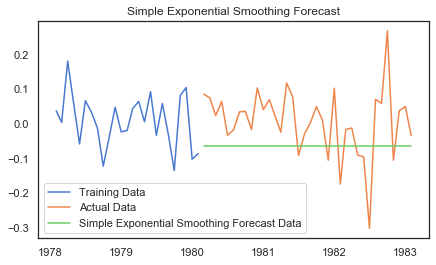

In [267]:
f_Method_SES=RF.Simple_Exponential_Smoothing_Forecast(df_in_sample, df_out_sample, 'CONTIL', 0.6)

In [268]:
f_Method_SES.head()

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1980-03-01,-0.065966,-0.021739,0.108678,0.00981,234.348543,18.179768,152.604285,0.013293,-0.000041,0.077533,0.041281
1980-04-01,-0.065966,-0.021739,0.108678,0.00981,234.348543,18.179768,152.604285,0.013293,-0.000041,0.077533,0.041281
1980-05-01,-0.065966,-0.021739,0.108678,0.00981,234.348543,18.179768,152.604285,0.013293,-0.000041,0.077533,0.041281
1980-06-01,-0.065966,-0.021739,0.108678,0.00981,234.348543,18.179768,152.604285,0.013293,-0.000041,0.077533,0.041281
1980-07-01,-0.065966,-0.021739,0.108678,0.00981,234.348543,18.179768,152.604285,0.013293,-0.000041,0.077533,0.041281


In [269]:
(df_out_sample-f_Method_SES).head()

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1980-03-01,0.150966,-0.100261,-0.351678,0.00200,5.451457,1.160232,-0.504285,0.001089,-0.003235,0.003117,-0.027683
1980-04-01,0.139966,0.005739,-0.028678,-0.00228,8.151457,2.110232,-4.304285,-0.002034,-0.024942,0.006137,-0.003841
1980-05-01,0.088966,0.046739,-0.046678,-0.00351,10.551457,2.830232,-8.604285,-0.003396,-0.028954,0.008257,-0.015944
1980-06-01,0.129966,0.082739,-0.022678,-0.00478,13.251457,3.350232,-11.104285,-0.002268,-0.017320,0.009422,-0.027706
1980-07-01,0.031966,0.132739,-0.043678,-0.00379,13.451457,4.080232,-12.204285,-0.012485,-0.007733,0.012297,-0.008210


In [270]:
((df_out_sample-f_Method_SES)**2).head()

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1980-03-01,0.022791,0.010052,0.123677,0.000004,29.718383,1.346138,0.254304,0.000001,0.000010,0.000010,0.000766
1980-04-01,0.019591,0.000033,0.000822,0.000005,66.446251,4.453079,18.526871,0.000004,0.000622,0.000038,0.000015
1980-05-01,0.007915,0.002185,0.002179,0.000012,111.333245,8.010212,74.033724,0.000012,0.000838,0.000068,0.000254
1980-06-01,0.016891,0.006846,0.000514,0.000023,175.601112,11.224054,123.305150,0.000005,0.000300,0.000089,0.000768
1980-07-01,0.001022,0.017620,0.001908,0.000014,180.941695,16.648292,148.944577,0.000156,0.000060,0.000151,0.000067


In [271]:
np.mean((df_out_sample-f_Method_SES)**2)

CONTIL          0.014358
IBM             0.004682
MARKET          0.015962
RKFREE          0.000006
CPI          1768.163085
POIL          108.838698
FRBIND        100.875058
RINF            0.000073
GIND            0.000157
real_POIL       0.000753
ROIL            0.003114
dtype: float64

In [272]:
np.std((df_out_sample-f_Method_SES)**2)

CONTIL          0.020123
IBM             0.005847
MARKET          0.023549
RKFREE          0.000007
CPI          1235.213421
POIL           73.032603
FRBIND         99.424877
RINF            0.000073
GIND            0.000189
real_POIL       0.000748
ROIL            0.003148
dtype: float64

In [280]:
np.mean((df_out_sample-f_Method_MAF_1)**2)

CONTIL               NaN
CPI          2605.754167
FRBIND        101.286233
GIND            0.000163
IBM             0.004186
MARKET          0.007982
MOBIL                NaN
POIL          183.487608
RINF            0.000046
RKFREE          0.000005
ROIL            0.003888
real_POIL       0.001451
dtype: float64

In [274]:
co_of_variation_Method_SES=np.std((df_out_sample-f_Method_SES)**2)/np.mean((df_out_sample-f_Method_SES)**2)
co_of_variation_Method_SES

CONTIL       1.401542
IBM          1.248733
MARKET       1.475277
RKFREE       1.116010
CPI          0.698586
POIL         0.671017
FRBIND       0.985624
RINF         1.011821
GIND         1.206223
real_POIL    0.994007
ROIL         1.011014
dtype: float64

In [275]:
MainDF_first_period.tail()

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1979-08-01,0.058,0.016,0.095,0.00789,221.1,14.00,152.1,0.010050,-0.005882,0.063320,0.035153
1979-09-01,-0.033,-0.032,0.039,0.00802,223.4,14.57,152.7,0.010403,0.003945,0.065219,0.030000
1979-10-01,-0.136,-0.079,-0.097,0.00913,225.4,15.11,152.7,0.008953,0.000000,0.067036,0.027860
1979-11-01,0.081,0.060,0.116,0.00819,227.5,15.52,152.3,0.009317,-0.002620,0.068220,0.017653
1979-12-01,0.104,-0.013,0.086,0.00747,229.9,17.03,152.5,0.010549,0.001313,0.074076,0.085839


In [276]:
MainDF_second_period.head()

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1980-01-01,-0.103,0.066,0.124,0.00883,233.2,17.86,152.7,0.014354,0.001311,0.076587,0.033897
1980-02-01,-0.087,-0.062,0.112,0.01073,236.4,18.81,152.6,0.013722,-0.000655,0.079569,0.038935
1980-03-01,0.085,-0.122,-0.243,0.01181,239.8,19.34,152.1,0.014382,-0.003277,0.080651,0.013599
1980-04-01,0.074,-0.016,0.080,0.00753,242.5,20.29,148.3,0.011259,-0.024984,0.083670,0.037440
1980-05-01,0.023,0.025,0.062,0.00630,244.9,21.01,144.0,0.009897,-0.028995,0.085790,0.025338


In [277]:
MainDF_1=MainDF_first_period.append(MainDF_second_period)

In [278]:
MainDF_1.head()

,CONTIL,IBM,MARKET,RKFREE,CPI,POIL,FRBIND,RINF,GIND,real_POIL,ROIL
Date,,,,,,,,,,,
1978-02-01,0.037,-0.043,0.010,0.00494,188.4,8.84,139.2,0.006410,0.002882,0.046921,0.011946
1978-03-01,0.003,-0.063,0.050,0.00526,189.8,8.80,140.9,0.007431,0.012213,0.046365,-0.011868
1978-04-01,0.180,0.130,0.063,0.00491,191.5,8.82,143.2,0.008957,0.016324,0.046057,-0.006625
1978-05-01,0.061,-0.018,0.067,0.00513,193.3,8.81,143.9,0.009399,0.004888,0.045577,-0.010435
1978-06-01,-0.059,-0.004,0.007,0.00527,195.3,9.05,144.9,0.010347,0.006949,0.046339,0.016722


In [281]:
np.mean((df_out_sample-f_Method_MAF_1)**2)

CONTIL               NaN
CPI          2605.754167
FRBIND        101.286233
GIND            0.000163
IBM             0.004186
MARKET          0.007982
MOBIL                NaN
POIL          183.487608
RINF            0.000046
RKFREE          0.000005
ROIL            0.003888
real_POIL       0.001451
dtype: float64